# Final Project

## 1. Introduction

### 1.1 Background
In my day job, I am a Human Resource Policy Analyst at the Public Service Division. As part of my daily work, I have to review compensation schemes from various agencies across various Ministries and Statutory Boards. One of the things I do very often as a part of my work is to read job descriptions and determine if a job falls into a particular archtype. This is very important for job benchmarking, because we want to be able to benchmark our Public Service jobs to appropriate job types in the market. 

This is of ever increasing importance as the Public Service moves away from the only mindset of "pay for the person" to a new paradigm of "paying for the job". Setting up the appropriate benchmarks and compensation for our officers will allow us to attract and retain the people we need to sustain a world-class Public Service for Singaporeans. 

Today, this process of benchmarking jobs is more of an art than science. I believe that I can use the techniques I have learnt in Foundations of Machine Learning to do perform this function in a much more efficient (and scientific) manner.  

In this project, I will explore various ways that I can feed job descriptions into simple machine learning algorithms and see how far I can get in developing tools to compare jobs descriptions and make predicitons with just these simple algorithms. 

### 1.2 Dataset

Since the actual, detailed job descriptions of jobs in the public service are classified, I will be using job descriptions from Careers@Gov as my dataset. This is openly available information that I have scrapped from the careers@gov website. The data consists of current job openings, which may not be representative of all the jobs in the Public Service, but it will suffice as a proof of concept.

The dataset is static to ensure reproducability for this homework. However, the code for the webscrapper can be found on my github at https://github.com/Yip-Jia-Qi/Careers-Gov-Webscrapper if you want an up-to-date dataset. It should theoritically run and pipedirectly into this jupyternotebook, however the structure of the website might change overtime and a different set of job descriptions would have to be cleaned differently. 

### 1.3 Overview of the project

The first problem I will tackle in the project is dimensionality reduction using PCA. In order to read job descriptions I must use TFIDF vectorization which creates a large number of dimensions, which I will attempt to reduce using PCA. I will then build a simple job recommender system using the latent dimensions of the PCA and then qualitatively asses the results. The latent dimensions obtain using this PCA method will then be used to make predictions in the second problem.

The second problem I will solve is to try and predict the job cetegory of the job based on the job description. However, in reality this is very difficult as there are a huge number of job categories in this dataset. For the purposes of this project, I will only work on predicting engineering jobs vs non-engineering jobs, which is a much easier problem but should still suffice to meet the requirements of the assignment. 

I will try to solve this problem using Gaussian Mixture Models, Linear Regression, Decision Trees, and Fully Connected Neural networks. I will perform hyper-parameter tunning and cross-validation for model selection at each section and compare the best result I can obtain with each method at the end. 

### 1.4 Contents of this notebook

#### Setting up
1. Introduction
2. Data Preparaion
3. Basic Data Visualization
4. Vectorizing the Job Descriptions

#### Unsupervised Learning
5. Principal Component Analysis
6. A Simple Job Recomender System
7. Gaussian Mixture Modeling

#### Supervised Learning
8. Linear Regression
9. Decision Trees
10. Fully Connected Neural Networks
11. Comparing the performance of the various models

The pre-trained models used for this project can be downloaded from this OneDrive Link: https://1drv.ms/u/s!AlNG26WLrzhkg7FCUvikzFM1RBVOrA?e=2Ty0nI

## 2. Data Preparation

Here I import most of the packages I will be using in this notebook as well as download my prepared data from my github repository. 

In [1]:
import nltk as nltk
import pandas as pd
import sklearn as skl
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime

In [2]:
url = "https://github.com/Yip-Jia-Qi/Careers-Gov-Webscrapper/raw/master/careers_gov_data_final.csv"
data = pd.read_table(url, sep= ",", encoding='windows-1252')
data.rename(columns={data.columns[0]:'job_id'},inplace=True)

### 2.1 Data Cleaning

column 6 is the job descriptions while column 4 is the job categories. Basically the goal is to turn all the job categories into a csv. Changing the / into a , is a conscious choise which will lead to proliferation of categories. Law/Legal Services is a single category, but it is easier to simply turn it into two categories. The same with things in brakets. We can probably reduce the categories later

In [3]:
data = data.fillna(" ")

for k in data['job_id']:
    i = k-1
    data.iloc[i,6] = data.iloc[i,6].replace(u'\xa0', u'')
    data.iloc[i,6] = data.iloc[i,6].replace(u'<U+F0B7>', u' ')
    data.iloc[i,4] = data.iloc[i,4].replace("/", ",")
    data.iloc[i,4] = data.iloc[i,4].replace("(", ",")
    data.iloc[i,4] = data.iloc[i,4].replace(")", ",")
    data.iloc[i,4] = data.iloc[i,4].replace("etc.", ",")
    data.iloc[i,4] = data.iloc[i,4].replace("e.g.", ",")
    data.iloc[i,4] = data.iloc[i,4].replace(", ", ",")
    
# Note to self: check rows 7 and 1360

In [4]:
data = data[data.iloc[:,6]!=" "].reset_index(drop=True) #Removes empty job descriptions

### 2.2 Vectorize the job categories

This is quite straight forward because there is very little noise compared to the vectorization of the job descriptions we are going to do later on. We have to use vectorization in this step instead of get_dummies because the job categories data can be one-to-many and not just one-to-one.

Note that the way that we did the data cleaning in the section above has implications on the vectorization in this step. We have intentionally created these job categories very liberally by splitting up some categories that would otherwise be together. 

For example, "Sciences (e.g. life sciences, bio-technology etc.)" would be split into three categories: Sciences, Life Sciences and bio-technology even though in the database it would be one category. Another example is "Economics/Statistics" - this would be split into two categories.

We can rely on machine learning to group this categories back together again later

In [5]:
job_cat = data.iloc[:,4]

def my_tokenizer(s):
    return s.split(",")

vectorizer_jobcat = CountVectorizer(
    analyzer='word', 
    ngram_range=(1,1), 
    decode_error='ignore',
    encoding='windows-1252', 
    lowercase = True,
    tokenizer = my_tokenizer
)

Y = vectorizer_jobcat.fit_transform(job_cat)
vector_frame_jobcat = pd.DataFrame(Y.toarray())
vector_frame_jobcat.columns = vectorizer_jobcat.get_feature_names()
vector_frame_jobcat = vector_frame_jobcat.drop([''],axis=1)
vector_frame_jobcat.head()

,accounting,administration support,arts,audit,bio-technology,building and estate management,business development,conciliation,corporate communications,corporate strategy,...,public service leadership,research and analysis,sciences,singapore armed forces,social and community development,statistics,technology,top management,training and development,translators
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
3,1,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now we add the vectorised job categories to the original dataframe, save it as a new dataset to use for our analysis later

In [6]:
data2 = pd.concat([data,vector_frame_jobcat],axis=1)

### 2.3 Preparing the data for visualization

Due to the high number of categories in this dataset, we first have to process the data a little further to make its digestable. 

In [7]:
#This df shows the total number of job postings posted by each agency

agency_count = pd.DataFrame(pd.to_numeric(data.groupby(['Agency']).count()['job_id']))

The code below creates a `agency_count_reduced` dataframe. This will allow me to plot only the agencies that have the largest number of job postings overall to use in my plotting. This is because there are too many agencies in this list to have proper visualizaton. The smaller agencies are all grouped together under the "Other" category. The number of agencies to show can be adjusted using the `nlargest` parameter in the first line of this block of code.

In [8]:
agency_count_reduced = agency_count.transpose()[agency_count['job_id'].nlargest(30).index].transpose()
temp = pd.DataFrame(data = {"job_id":[agency_count['job_id'].sum(axis=0) - agency_count_reduced['job_id'].sum(axis=0)]},index=['Others'])
agency_count_reduced = agency_count_reduced.append(temp)
agency_count_reduced['Percentages']=round((agency_count_reduced['job_id']/agency_count_reduced['job_id'].sum())*100,1)

and the same thing again to the number of job categoreis

In [9]:
jobcat_reduced = pd.DataFrame(vector_frame_jobcat.sum(axis=0)[vector_frame_jobcat.sum(axis=0).nlargest(25).index])
top25_jobcat = vector_frame_jobcat[vector_frame_jobcat[jobcat_reduced.index.tolist()].sum(axis=1)!=0]
other_jobcat = len(vector_frame_jobcat[vector_frame_jobcat[jobcat_reduced.index.tolist()].sum(axis=1)==0])
jobcat_reduced = jobcat_reduced.transpose().assign(Others = other_jobcat).transpose()
perc_jobcat = round((jobcat_reduced/len(data))*100,2)
jobcat_reduced = jobcat_reduced.assign(Percentage = perc_jobcat)

In [10]:
vector_frame_jobcat[['infocomm','technology','new media communications']].sum(axis=1).unique()

array([3, 0], dtype=int64)

Note that infocomm, technology and new media communication is part of the same job category and not three seperate job categories. There are other job categories that might be similarly repeated, but this one is the largest by far.

## 3. Basic Data Visualization

This this data visualization section, my goal is to understand abit more about the type of jobs I have in my dataset. My data is obtained as a snapshot of the careers@gov page, so the data I have will simply be influenced by whatever agency happens to he hiring at the time. 

Next are two barplots that will actually be useful to aid in our understanding of the dataset. This first bar plot shows the top 30 largest job posters, and we can see that GovTech and LTA lead are the largest by a large margin. The remaining job posters have a relatively even propostion of the jobs, although MINDEF, IMDA and ITE could still be considered very large employers in this dataset.

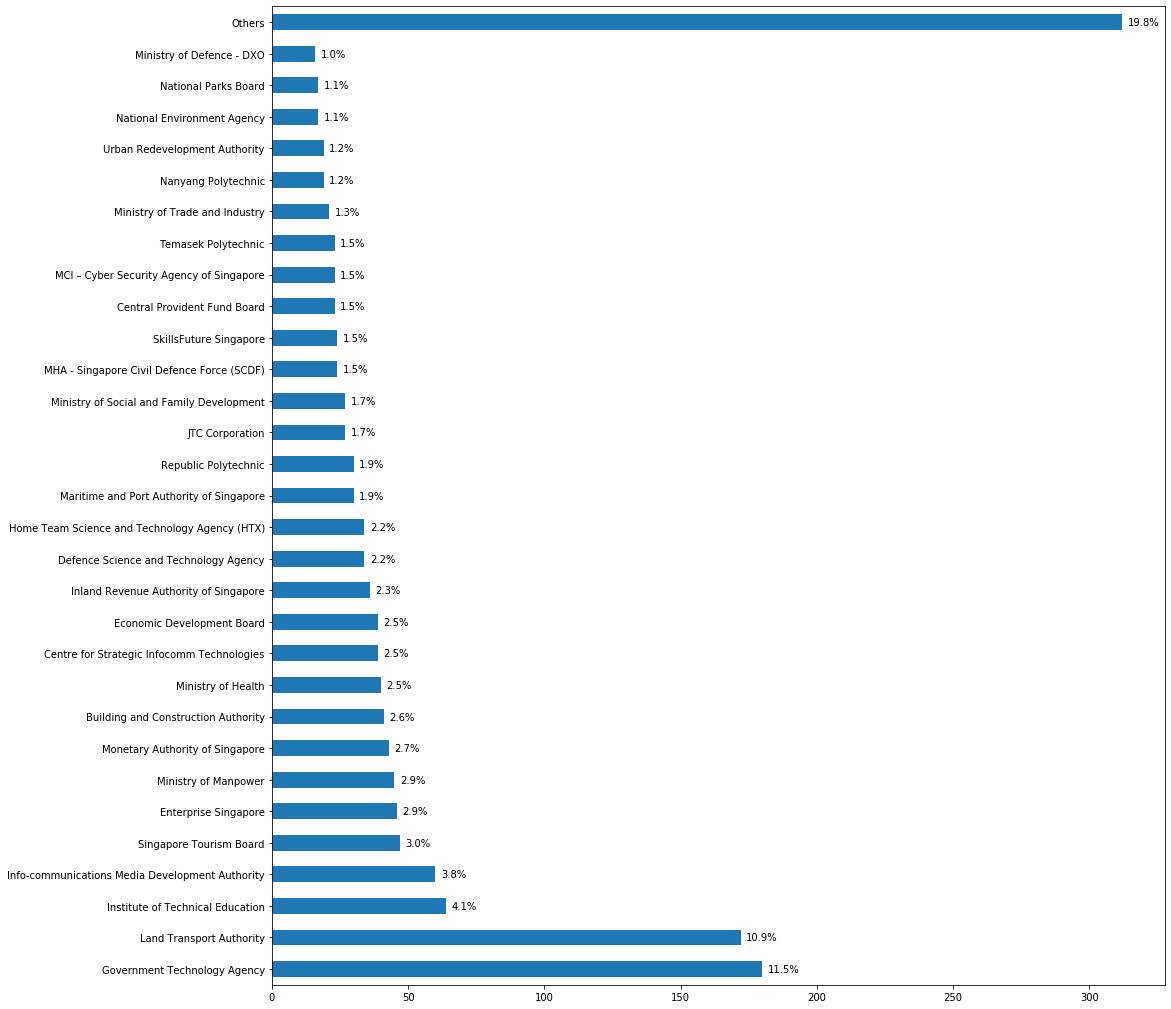

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(16, 18))
agency_count_reduced['job_id'].plot.barh(grid=False)
n=0
for p in ax.patches:
    percentage = str(agency_count_reduced['Percentages'].iloc[n])+"%"
    x = p.get_x() + p.get_width()+2
    y = p.get_y() + p.get_height()/2 - 0.1
    ax.annotate(percentage, (x, y))
    n+=1   

The second bar plot shows the proportion of job category tagging. Each job can have multiple job categories, and some of the job categories have actually been split into multiple job categories artificaially by my vectorization. However, this gives us an overview of the types of jobs that are in this dataset. A surprise here is that engineering is actually the 4th job category, and contributes a smaller proportion by some margin. The top 3 are technology, new media communicaitons and infocomm. These sound like they are contributed by IMDA mroe than GovTech. Again, it is likely that GovTech was again not very dilligent in their job category mapping. This will have to be taken into consideration later when we try to use job descriptions to predict job categories. 

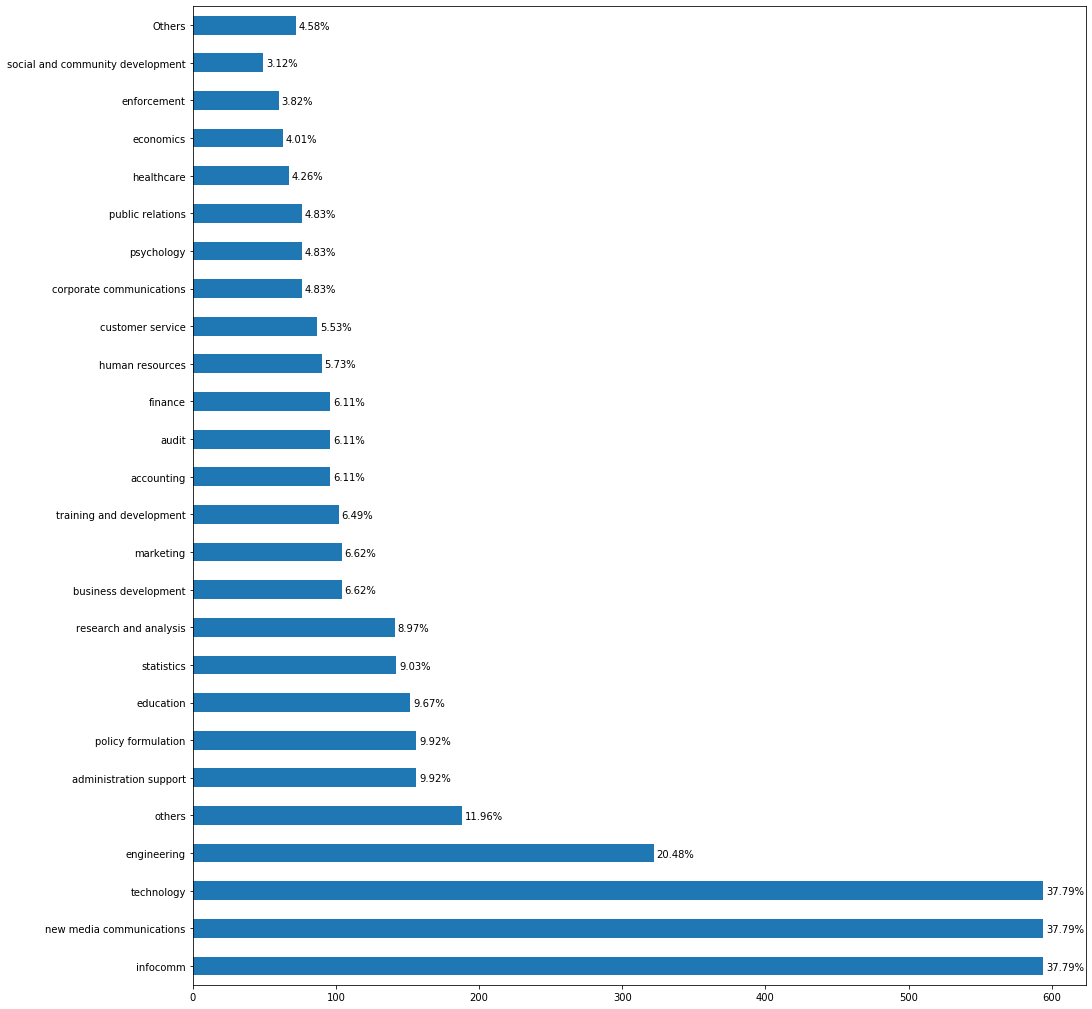

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(16, 18))
jobcat_reduced.iloc[:,0].plot.barh(grid=False)
n=0
for p in ax.patches:
    percentage = str(jobcat_reduced['Percentage'].iloc[n])+"%"
    x = p.get_x() + p.get_width()+2
    y = p.get_y() + p.get_height()/2 - 0.1
    ax.annotate(percentage, (x, y))
    n+=1   

## 4. Vectorizing the Job Descriptions

Now for the first part of the main event. In order for the job descriptions to be processed, they need to be converted into a format that is digentable by machine learning, ie vectors. A very simplisitic approach of doing this is simply counting up the number of times each unique word in the entire dataset appears in each job description. Another way is to include short phrases in the mix as well, although will cause the "dictionary" dimension of the verctor (ie the number of columns) to explode.

In [13]:
job_desc = data.iloc[:,6]

### 4.1 Applying a TF-DIF Transformation

TFIDF stands for Term Frequency-Inverse Document Frequency. Term Frequency is the number of times a word appears in a document divided by the total number of words in that document. This essentially produces the percentage prequency of a particular word in a particular document.
Inverse Data Frequency is calculated by the number of documents divided by the number of documents that contain a particular word, then taking the log. The more often a word appears, the closer the fraction is to 1, and the log of it approaches 0. If a word is very rare, then the fraction becomes very large, but the IDF will slow that growth by taking the log. 
TF-IDF is the term frequency multiplied by the Inverse Data Frequency, which highlights a word if it is a rare word that appears very often in a particular documents, and demphasizes common words that appear in every document, but gives it more weightage if it appears alot in a particualar document. 

First, I import the necessary packages. 

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

The first TF-IDF vectorizer I will impleement uses the parameter ngram_range=(1,3) this means that it will look out for short phrases as well as single words. This may be useful as it helps us capture some of the sequential nature inherent in our sentences. 

In [15]:
tf = TfidfVectorizer(analyzer='word', ngram_range=(1, 3), min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(job_desc)
Y = tfidf_matrix.todense()

In [16]:
visualize_tfidf_matrix = pd.DataFrame(tfidf_matrix.toarray())
visualize_tfidf_matrix.columns = tf.get_feature_names()
visualize_tfidf_matrix.head()

,000,000 10,000 10 000,000 100,000 100 750,000 benefits,000 benefits 14,000 confirmation,000 confirmation year,000 local,...,zoom meetings cisco,zoom ms,zoom ms teams,zoom practical,zoom practical implementation,zoonotic,zoonotic disease,zoonotic disease biosurveillance,zoonotic diseases,zoonotic diseases rabies
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Looking at the table of the vectorization, we see that post of the nonsence words and phrases that should have not immedite usefulness are set to zero or close to zero, which is good. The number of columns is more that 300k which is rather large and unweildly. 

Next, I will perfrom the same vectorization by with ngram_range=(1,1). This should reduce the number of columns

In [17]:
tf2 = TfidfVectorizer(analyzer='word', ngram_range=(1, 1), min_df=0, stop_words='english',encoding='windows-1252')
tfidf_matrix2 = tf2.fit_transform(job_desc)
Z = tfidf_matrix2.todense()

In [18]:
visualize_tfidf_matrix2 = pd.DataFrame(tfidf_matrix2.toarray())
visualize_tfidf_matrix2.columns = tf2.get_feature_names()
visualize_tfidf_matrix2.head()

,000,00am,00pm,01,0336,04,040,0630hrs,10,100,...,zendesk,zepplin,zero,zigbee,zipkin,zone,zookeeper,zoology,zoom,zoonotic
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Here we see a mroe managable number of columns, but this may come at the cost of losing some of the important sequential information we might want from phrases.

### 4.2 Visualizing the "Fingerprints" of the Job Descriptions

By plotting histograms of the first job description from each of the types of vectorizations, we can see a "fingerprint" of the job description, which is a visualization of how the vector is representing the text. 

Interestingly, but in hindsight not unsurprisingly, although the 10k column vectorization has fewer parameters, it appears that there are more features to be found in the fingerprint, while the 300k column vectorization seems a little more featureless as there is a large number of keywords stuck at the 0.05 level. This may mean that the 10k column vectorization is better, but we will see when we do the Principal Component Analysis.

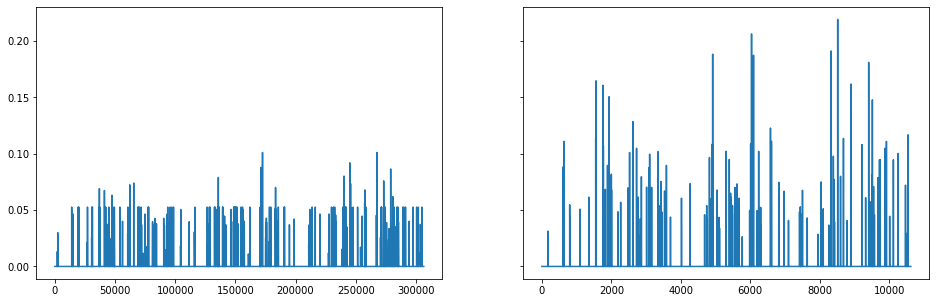

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5),sharey = 'row')
ax[0].plot(np.asarray(Y)[0])
ax[1].plot(np.asarray(Z)[0])

## 5. Dimensionality Reduction with Principal Component Analysis (PCA)

The goal of performing the PCA analysis is to to dimensionality reduction on the job descriptions. The number of dimensions used to describe the job descriptions in this dataset is extrodinarily high because of the nature of the text vectorization method. Each word has to be its own dimension. 

With PCA, we want to reduce the number of dimensions by creating latent dimensions that will capture most of the variance among the job descriptions without using so many dimensions. Intuitively, we can think of this as certain groups of keyword within the job descriptions being more important than others in capturing the differences between each job description. 

Since I have made two kinds of vectorizations with very different number of dimensions, I will try PCA with both and see what kind of results I get

To start, the code below installs the the necessary packages

In [20]:
from sklearn.decomposition import PCA
import seaborn as sns

This package is for saving and loading the stored models

In [21]:
import pickle
from joblib import dump, load

WARNING: THIS NEXT FEW STEP MAY TAKE AWHILE IF N_COMPONENTS IS TOO BIG. 

I have pre-trained the model so it can just be loaded without going through the training.

The first PCA attempt used the 300k column dataset with 100 components as a first cut.

In [22]:
#pca = PCA(n_components=100)
#pca.fit(Y)
#dump(pca,'careers gov JD 100 components.joblib')
pca = load('careers gov JD 100 components.joblib')

### 5.1 First PCA

Plotting this first PCA attempt to see how the observed variance decays with the number of principal components

Text(0.5, 1.0, 'explained variance log scalling')

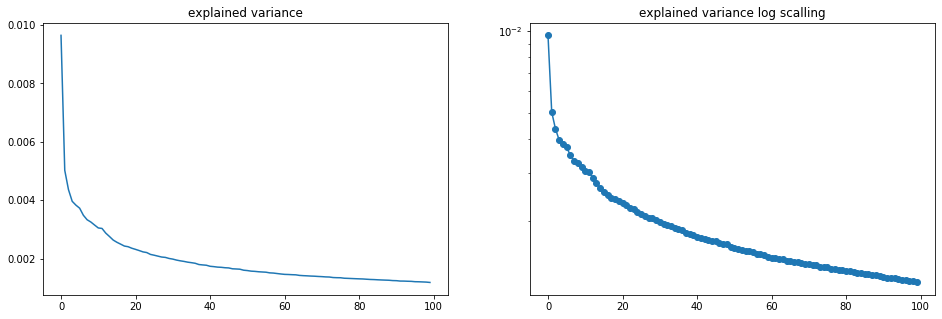

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))
ax[0].plot(pca.explained_variance_)
ax[1].semilogy(pca.explained_variance_, '-o')
ax[0].set_title(label = "explained variance")
ax[1].set_title(label = "explained variance log scalling")

As we can see from the graphs, the variance explained does not quite reach 0 like we would hope. The log scaling also does not reveal any features that we might be able to use to set a cut-off point for the number of components to use.

### 5.2 Second PCA

Second attempt at PCA using the second tfidf vectorizer where `ngram_range` is set to `(1,1)` which reduces the numnber of columns that need to be trained. This allows us to drastically increase the value of `n_components` dramatically whithout having to use too much computing resources. Even with `n_components = 1000` this should still be runnable, but I have just saved and pre-trained the model anyway.

In [24]:
#pca2 = PCA(n_components=1000)
#pca2.fit(Z)
#dump(pca2,'careers gov JD_ngram1 vectorization_1000 components.joblib')
pca2 = load('careers gov JD_ngram1 vectorization_1000 components.joblib')

Text(0.5, 1.0, 'explained variance log scalling')

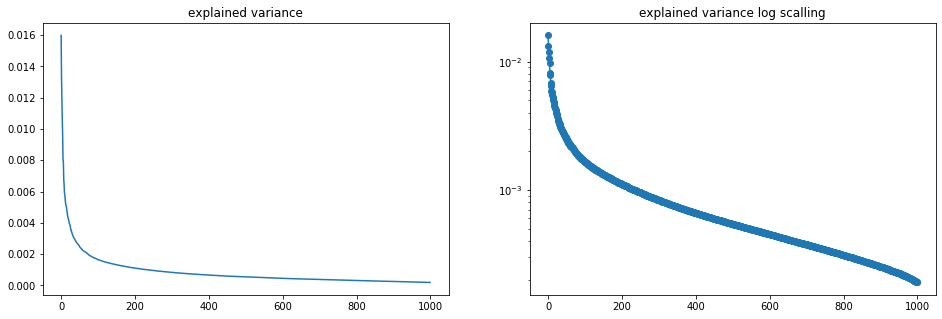

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))
ax[0].plot(pca2.explained_variance_)
ax[1].semilogy(pca2.explained_variance_, '-o')
ax[0].set_title(label = "explained variance")
ax[1].set_title(label = "explained variance log scalling")

We can see from the second plot that the explained variance never really drops off drastically at some point. However in this second case the first 2000 components will probably be pretty good. 

### 5.3 Third PCA

Third attempt at PCA. This time I will use back the Y vectorization method but increase the number of `n_components`. This time it really will take awhile. Again, model has been pre-trained.

In [26]:
#pca3 = PCA(n_components=500)
#pca3.fit(Y)
#dump(pca3,'careers gov JD 500 components.joblib')
pca3 = load('careers gov JD 500 components.joblib')

Text(0.5, 1.0, 'explained variance log scalling')

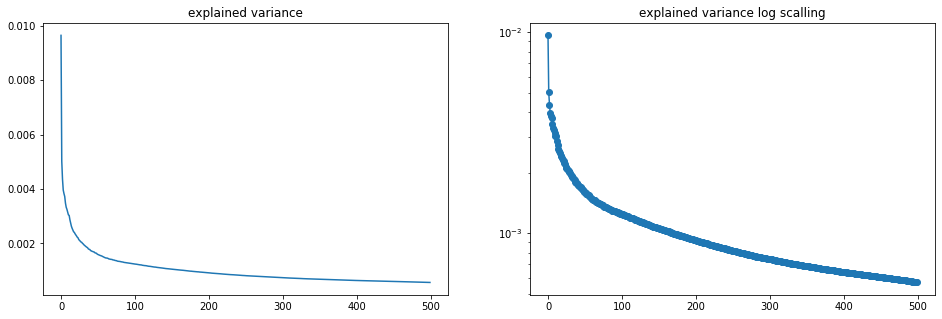

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))
ax[0].plot(pca3.explained_variance_)
ax[1].semilogy(pca3.explained_variance_, '-o')
ax[0].set_title(label = "explained variance")
ax[1].set_title(label = "explained variance log scalling")

It seems that after all this testing, there is not that much to be gained beyond around the 100-150 components of the first pca model. Since the goal is reducing the number of dimensions, we just have to make a "cost-benefit" call on how many components to keep. In this case, we will make a somewhat arbitary decision to use 150 pricipal components. 


### 5.4 Chosing the Vectorization dataset

The next decision is whether to take the Z (10k columns) or Y (300k columns) vectorization dataset.

Text(0.5, 1.0, 'Z Vectorization (10k dimensions)')

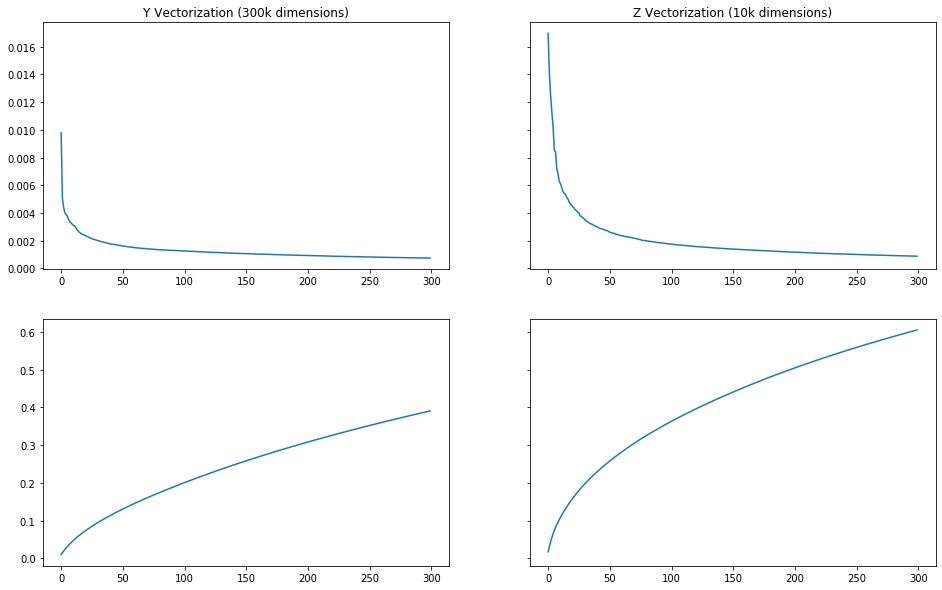

In [28]:
fig, ax = plt.subplots(2, 2, figsize=(16, 10),sharey = 'row')
ax[0,0].plot(pca3.explained_variance_ratio_[0:300])
ax[0,1].plot(pca2.explained_variance_ratio_[0:300])
ax[1,0].plot(np.cumsum(pca3.explained_variance_ratio_[0:300]))
ax[1,1].plot(np.cumsum(pca2.explained_variance_ratio_[0:300]))
ax[0,0].set_title(label = "Y Vectorization (300k dimensions)")
ax[0,1].set_title(label = "Z Vectorization (10k dimensions)")

In [29]:
print(f'For the first 150 principal components:')
print(f'Variance explained using vectorized dataset Y: {round(np.cumsum(pca3.explained_variance_ratio_)[150],5)}')
print(f'Variance explained using vectorized dataset Z: {round(np.cumsum(pca2.explained_variance_ratio_)[150],5)}')

For the first 150 principal components:
Variance explained using vectorized dataset Y: 0.25843
Variance explained using vectorized dataset Z: 0.44093


Given that the explained variance is measuring the distnace between each of the 1680 original datapoints, it does not necessarily matter that the Y vectorization uses 300k dimensions while the Z vectorization uses 10k dimensions. The model with the better cumulative difference for the same number of latent dimensions should be the better model.

The reason why the vectorization with fewer dimensions does better is likely because having short phrases does not necessarily help identify the job descriptions better.

For example, one of the EDB job descriptions has a phrase something like "Singapore's dynamic digital economy". The Y vectorization would turn this into more than 9 vectors (including the words before and after the phrase) which don't necessarily help us describe the data better. It seems from my analysis (which I won't lay out in this jupyter notebook to keep things concise) that "dymanamic digital" and "dynamic digital economy" might be better off just described at "dynamic", "digital" and "economy" because the PCA done on the Y vectorization still picks out single words as key features. Essentially the extra dimensions, in this case, creates unecessary variation for the latent dimensions to explain, which is why I think the explain variance goes to zero much much slower. I think of the large number of unecessary dimensions as sort of a baseline of noise that cannot be explained by the PCA. 

Initially I had hoped that by vectorizing the short phrases as well, the PCA would pick out useful short phrases for analysis, but it seems that this is not necessary. 

Henceforth we will adopt the latents produced by `pca2` and dataset `Z` under the assumption that it best describes our data. Although we have generated 1000 latents, there is no need to utilize the full 1000 latent dimensions because the original goal of this project was to reduce the number of dimensions. We will stick to the first 150 dimensions which explains about 45% of our variance.

### 5.5 Visualizing the explained variances

Now that we have decided on the model and the dataset we can proceed with calculating the latent dimensions. 

The following creates an array of the latent dimensions that we will use later

In [30]:
latents = pca2.transform(Z)

The table `components_df` will help us see the latent dimensions with respect to their origial dimensions. The number of rows is the number of latend dimensions we have in our model, while the number of columns is the number of dimensions we originally had.

In [31]:
components_df = pd.DataFrame(pca2.components_)
components_df.columns = tf2.get_feature_names()
components_df

,000,00am,00pm,01,0336,04,040,0630hrs,10,100,...,zendesk,zepplin,zero,zigbee,zipkin,zone,zookeeper,zoology,zoom,zoonotic
0,-0.001157,-0.001001,-0.000500,-0.012223,0.000152,-0.000151,-0.000203,-0.000438,0.000895,0.002010,...,-0.000335,-0.000105,0.005911,0.000203,0.000492,-0.000026,0.000103,-0.001239,-0.001626,-0.000371
1,0.000066,-0.000351,-0.000176,-0.003800,-0.000366,-0.000055,-0.000086,-0.000210,-0.006232,-0.000884,...,0.004245,-0.000063,-0.001555,0.001073,0.000037,-0.000062,0.000821,-0.000692,0.000005,-0.000143
2,0.000728,0.000358,0.000179,0.009440,-0.000110,-0.000310,0.000211,0.000283,0.002063,0.000481,...,0.000078,-0.000780,0.006034,0.000007,-0.000375,0.000223,-0.000509,0.000588,-0.001367,0.000033
3,-0.000192,0.000120,0.000060,0.025850,-0.000959,-0.000311,-0.000024,-0.000010,0.008403,-0.001144,...,-0.000299,-0.000411,-0.001356,0.000425,0.000371,0.003728,-0.000117,0.000246,-0.002555,0.000085
4,-0.000391,0.001006,0.000503,0.017869,0.000756,0.000081,0.000143,0.000290,-0.001691,-0.001627,...,0.000310,0.000763,0.001868,0.000266,-0.000416,0.002000,0.000677,0.000884,-0.001542,0.000608
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.017673,0.004306,0.002153,0.004855,0.007619,-0.000713,0.003423,0.000666,-0.002010,0.005454,...,-0.012254,-0.005768,-0.014235,-0.000936,0.001010,-0.003980,0.000872,0.002176,-0.005170,-0.007626
996,-0.005873,0.007984,0.003992,0.000934,-0.001593,-0.001032,-0.001364,-0.002292,0.022609,-0.010284,...,-0.003293,0.001998,0.004238,0.001049,0.003490,0.030051,-0.001514,-0.010104,-0.003964,-0.004838
997,-0.000647,0.007306,0.003653,-0.000275,0.001650,-0.001555,0.000028,0.003913,-0.002903,-0.005423,...,0.003996,0.003255,-0.017452,-0.006186,0.000272,0.005639,0.004381,-0.000970,-0.011164,0.001476
998,0.002725,0.005079,0.002539,-0.003656,0.004653,-0.001738,-0.000748,0.000169,0.027132,-0.001982,...,-0.001113,0.002533,-0.005882,-0.004308,-0.000652,-0.006133,-0.001585,0.004444,0.012433,0.009732


The following functions allows me to return the n most relevant words from each principal components to give us an understanding of that each of these pricipal components are picking out.

top_comp returns a list of the top weighted words in the pricipal component
top_comp_df returns a dataframe with the top weighted words and their weights
top_comp_barplot returns a barplot to help visualize the various components

Note that the counting of variable 'component' starts from 0, but we will start counting latent dim from 1. i.e component=0 gives 'Latent dim 1'

In [32]:
def top_comp(component,num_words):
    red_comp = pd.DataFrame(abs(components_df.iloc[component,:]).nlargest(num_words, keep = 'all'))
    return red_comp.index

def top_comp_df(component,num_words):
    red_comp = pd.DataFrame(components_df[top_comp(component,num_words)].iloc[component,:])
    return red_comp

def top_comp_barplot(component,num_words,x=16,y=8):
    fig, ax = plt.subplots(1, 1, figsize=(x, y))
    sns.barplot(x = top_comp_df(component,num_words).iloc[:,0], y=top_comp_df(component,num_words).index, orient='h',ax=ax)
    ax.set_title(f'Latent dim {component+1}', {'fontsize': 16})

Testing out the barplot funciton below. 

Looking at the top 10 keywords from the top 2 latent dimensions we see that they are mainly positive. The keywords are mainly topical. The first latent dimension seems to be more technology oriented, while the second latent is more teaching related. The third dimension, however, looks very different from the first two. There is no clear trend among the keywords and it is not obvious from just this very basic analysis what the latent is identifying

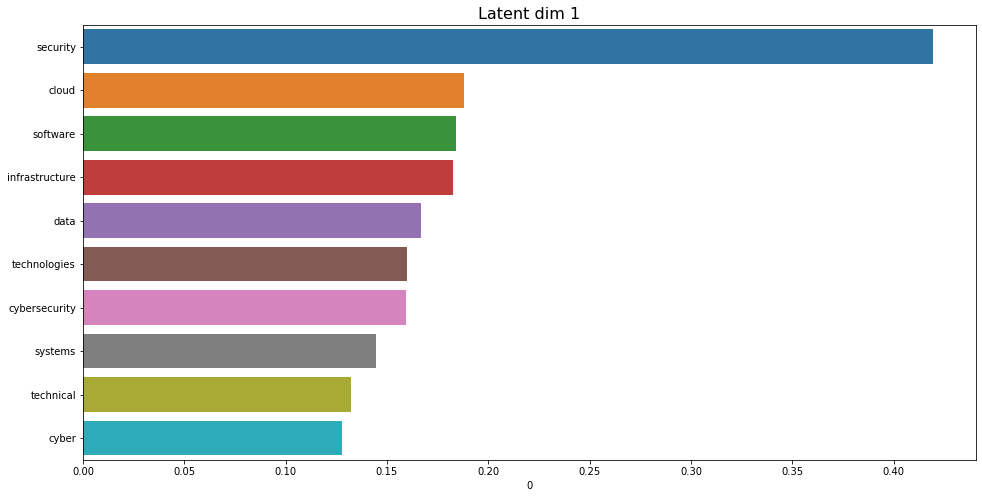

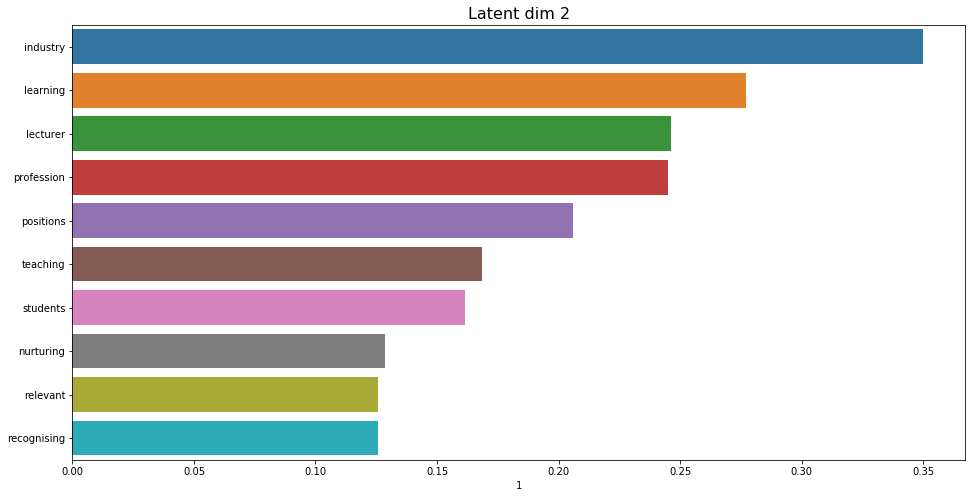

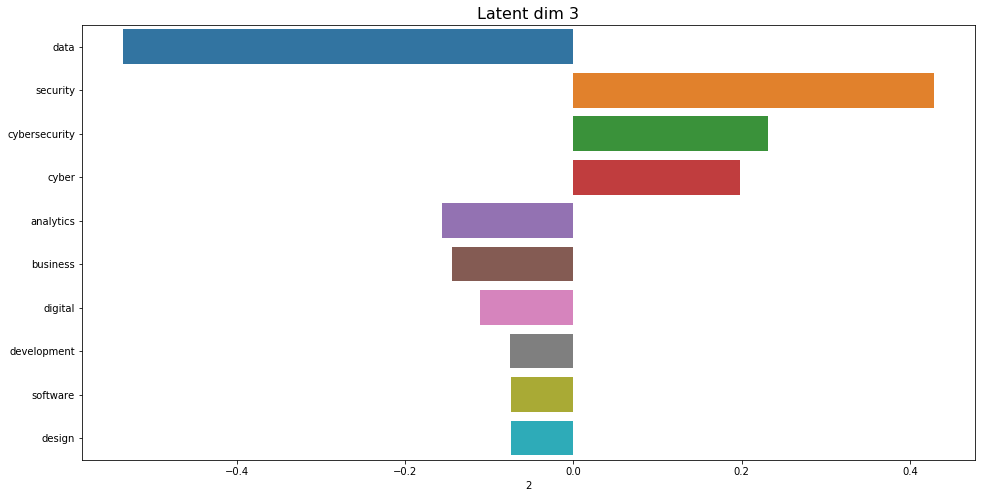

In [33]:
top_comp_barplot(0,10)
top_comp_barplot(1,10)
top_comp_barplot(2,10)

Next we take a latent that is somewhere in the middle, say the 71st latent dimension and plot the top 50 keywords. When we do a comparison of these two barplots we notice that the plot of the 71st latent looks abit more symetrical. This makes sense because the variance explained by these latent dimensions are much smaller than the first few latents. This means that the differences between the datapoints that these latents are picking out are probably much more subtle as well

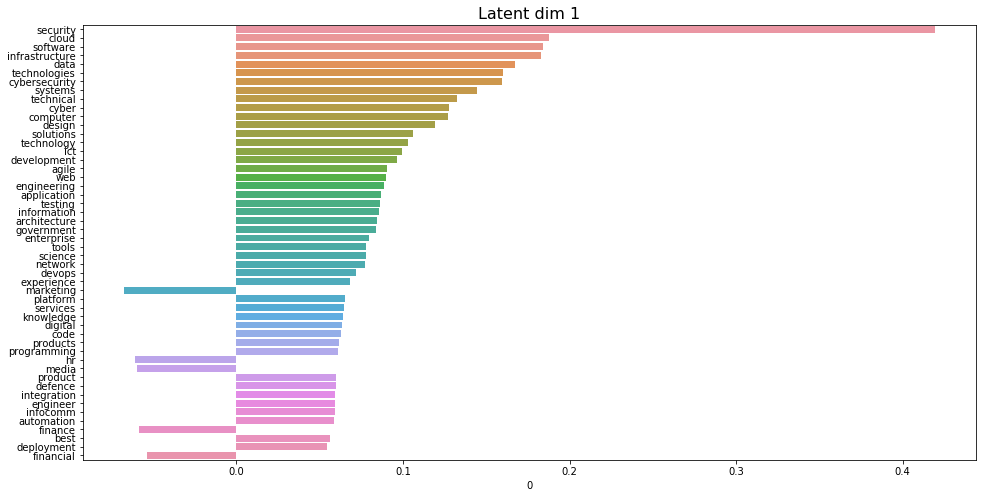

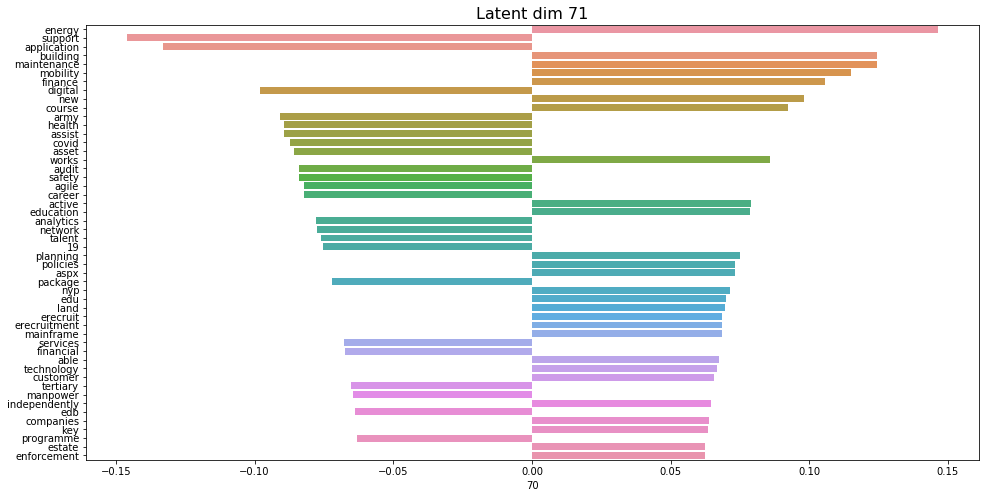

In [34]:
top_comp_barplot(0,50)
top_comp_barplot(70,50)

Next, I will create two dataframes for to use for referencing purposes. one will be latents_readable where I name the columns according to the top three keywords from each latent dim, while the second one will be latents_num where I just number off the latent dims starting from 1.

In [35]:
latents_readable = pd.DataFrame(
    data=latents,
    columns=[f'{"/".join(top_comp(i,3))}' for i in range(latents.shape[-1])],
)

latents_num = pd.DataFrame(
    data=latents,
    columns=[f'Latent dim {i+1}' for i in range(latents.shape[-1])],
)

Plotting the "fingerprints" of the job descriptions using the new PCA dimensions

<BarContainer object of 150 artists>

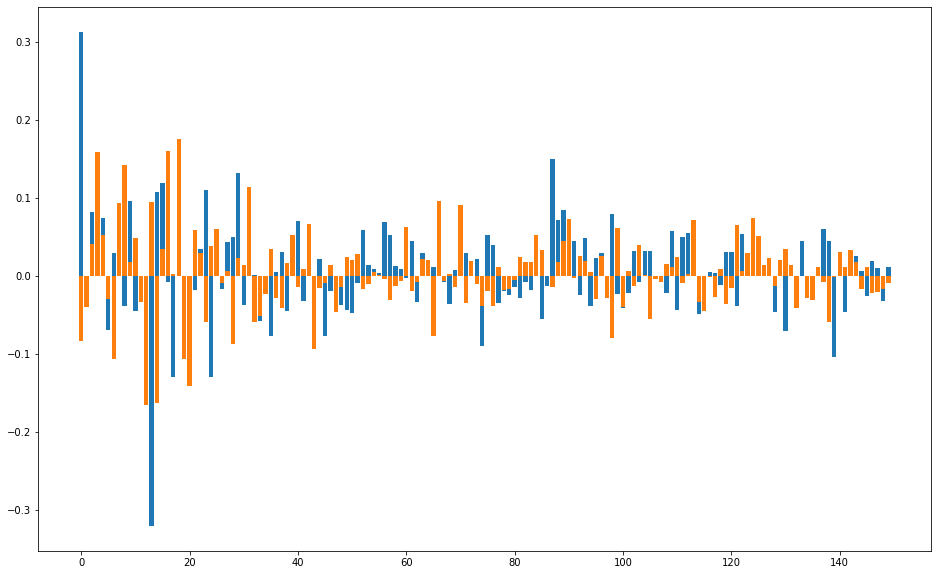

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(16, 10))
plt.bar(range(0,150),np.transpose(latents)[0:150].transpose()[0])
plt.bar(range(0,150),np.transpose(latents)[0:150].transpose()[1000])

Comparing this to the "figerprints" from just using the basic tokenizationg without PCA. 

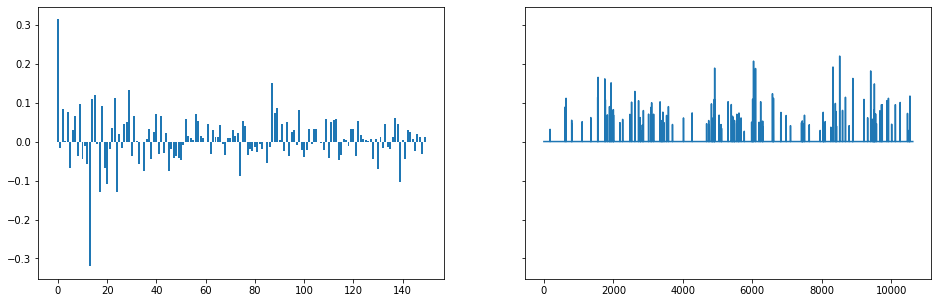

In [37]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5),sharey = 'row')
ax[0].bar(range(0,150),np.transpose(latents)[0:150].transpose()[0])
ax[1].plot(np.asarray(Z)[0])

Now I will define another function to help me plot scatter plots of the latent dimensions to visualize how the data is being seperated

In [38]:
def latent_sctplt(dim1,dim2):
    sns.scatterplot(
        x=latents_num.iloc[:,dim1],
        y=latents_num.iloc[:,dim2]
    )

Try a few scatter plots here

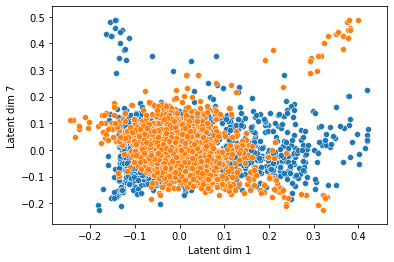

In [39]:
latent_sctplt(0,6)
latent_sctplt(7,6)

Some of the latents show very clearly that the are splitting one one group of of jobs from the rest. However, in my plots it could be helpful if we could color the jobs according to which agency they come from, but that would require much more data cleaning for limited benefit (although it would be worthwhile to do if I have time).

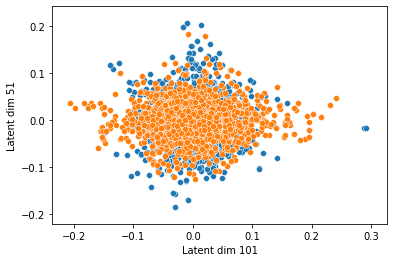

In [40]:
latent_sctplt(100,50)
latent_sctplt(30,140)

Some other comparisons show that they are rounder and maybe don't differentiate the jobs as much. But there are still some regions where is seems like it might be identifying some group. 

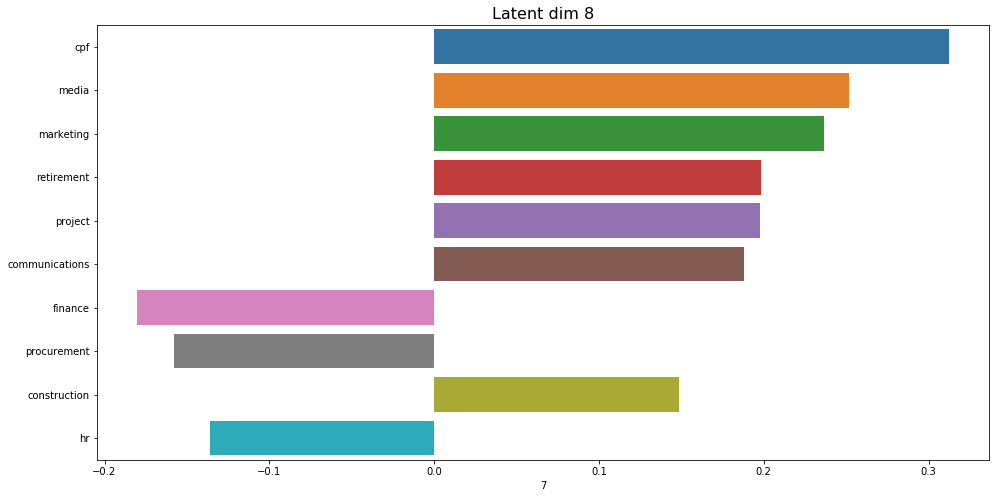

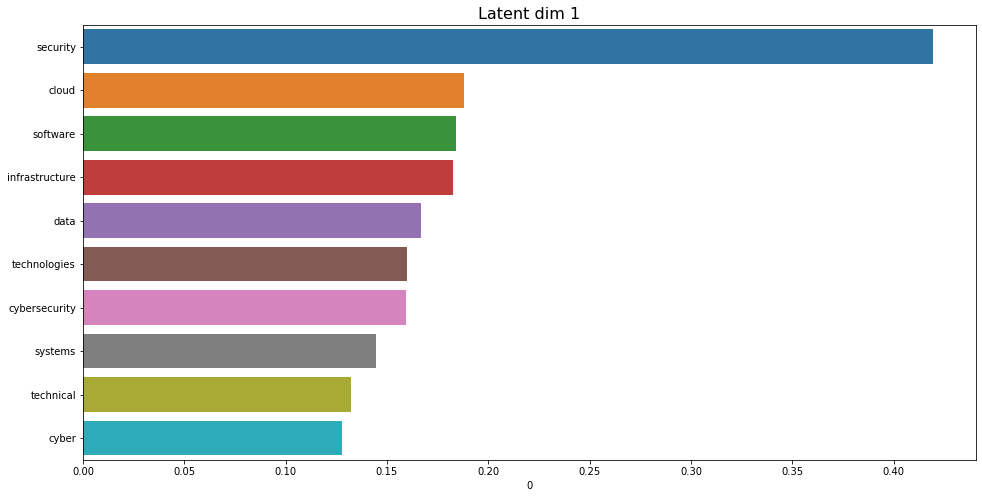

In [41]:
top_comp_barplot(7,10)
top_comp_barplot(0,10)

If we look at the keywords for latend dimension 1 and 8 from the first scatter plot, we can see very qualitatively that the jobs they are likely to come from may be very different. Latent Dim 1 is very tech-based while latent dimension 8 consists of keywords that are more often associated with corporate functions. 

### 5.6 Conclusion to PCA section

In this section we have successfully performed PCA and showed with a few brief visualization examples that the latent dimensions created by the PCA does indeed identify some features in the data. By looking at the top keywords from the various latent dimensions, we can qualitatively see that some of them seem to be related to one another within the latent dimension. This is interesting given that this is an unsupervised machine learning method. 

## 6. A Simple Job Recomender System

First we create the dataframe data3 which has all the information from data2 that was created earlier, plus the first 150 latent dimensions from our PCA.

In [42]:
data3 = pd.concat([data2,latents_num.iloc[:,0:150]],axis=1).reindex(data2.index)

## Note latents begin on the 65th column ie data3.iloc[:,64:]

Below defines the function for the simple job recomender called `recommend` which simply compares the distance between point in the 150 dimension space created for by our PCA that we are using to describe our jobs. It measures how "far" each job is from the selected job in the PCA space, and assumes that the "closest" jobs are the most similar jobs and thus recomends them.

the `read_jd` function allows us to actually see the job descriptions of the recomended jobs. I chose to do this seperately because I want to read the whole jd, but I don't necessarily want to read every recomened jd at the same time.

This function has also been implemented in R as a shinny app, which pay provide a better user interface for using the job recommender than this python notebook. The shinny app can be found here: https://yipjiaqi.shinyapps.io/Job_Recomender_betav1/

In [43]:
def recommend(job_id, num_recs=5):
    """
    A simple recommender system using PCA
    
    job_ids begin from 1.
    """
    
    row = pd.Index(data3['job_id']).get_loc(job_id)
    
    print(f'\033[1mYou selected:\033[0m\n{data3.job_titles[row]}')
    
    #NOTE TO SELF: actual index of the job beins from 0, so to refer to the job correctly we must always use job_id-1.
    
    # Convert the latent dimension dataframe into an array for calculations
    scores = data3.iloc[:,64:].to_numpy()
    
    # Compute L^2 distances to the input Score
    distances = np.sum((scores - scores[row,:])**2, axis=1)
    
    # Return recommendations based on closest products in PCA latent space
    rec_idx = np.argsort(distances)[1:1+num_recs] #this sorts the array from smallest to largest, then returns the indexes of the sorted array, not the actual value. the 0th element is the selected job_id. 
    rec_ids = data3.job_id[rec_idx]
    rec_title = data3.job_titles[rec_idx].to_numpy() #this returns an array of job titles using the previously acquired array of indexes
    rec_distance = distances[rec_idx] #this returns the actual L^2 distances of the recomendation. This is imporatant for explaining to the user how "confident" we are in our recomendation
    
    
    #this part prints us our output
    print('\n\033[1mWe recommend:\033[0m')
    for i, d, e in zip(rec_ids, rec_distance, rec_title):
        print(f'Job Id: {i} | distance: {round(d,3)} | Job title: {e}')
    print(f'\nNote: The closer "distance" is to 0, the more confident we are of our recomendation')
        
def read_jd(job_id):
    """
    A simple search function to return basic information about the job and read the job descriptions
    
    job_ids begin from 1.
    """
    row = pd.Index(data3['job_id']).get_loc(job_id)
    
    print(
        f'Job ID: {data3.job_id[row]}\n' #job_id-1 which is the index should match the job_id column
        f'\033[1mJob Title:\033[0m {data3.job_titles[row]}\n'
        f'\033[1mAgency:\033[0m {data3.Agency[row]}\n\n'
        f'\033[1mJob Description:\033[0m{data3.job_descriptions[row]}'
    )

In [44]:
len(data)

1572

In [45]:
recommend(558)

You selected:
Analyst/Senior Analyst/Lead Analyst (Compensation & Organisational Design), HR Policy

We recommend:
Job Id: 165 | distance: 0.102 | Job title: Analyst / Senior Analyst / Lead Analyst (Performance Management)
Job Id: 580 | distance: 0.141 | Job title: Assistant Executive/Senior Assistant Executive (Compensation & Organisational Design), HR Policy
Job Id: 734 | distance: 0.198 | Job title: Assistant Analyst / Analyst (HR Transformation) #SGUnited
Job Id: 687 | distance: 0.301 | Job title: Senior / Early Childhood Officer (Sector HR Development/Policy, Planning and Development Division), ECDA
Job Id: 259 | distance: 0.327 | Job title: Executive/Senior Executive/Manager (Leadership Capabilities), Leadership Development

Note: The closer "distance" is to 0, the more confident we are of our recomendation


In [46]:
recommend(500)

You selected:
Senior Manager / Manager (Member Accounts) – Contract

We recommend:
Job Id: 258 | distance: 0.058 | Job title: Senior Manager / Manager / Assistant Manager (Retirement Withdrawals) - Contract
Job Id: 496 | distance: 0.059 | Job title: Senior Manager / Manager (Policy) - contract
Job Id: 429 | distance: 0.07 | Job title: Assistant Director / Senior Manager (Retirement Withdrawals) - Contract
Job Id: 296 | distance: 0.082 | Job title: Senior Manager/Manager (MediShield Life Policy Administration & Premium Recovery) – Contract
Job Id: 494 | distance: 0.087 | Job title: Senior Manager/ Manager (Housing Schemes Department) - Contract

Note: The closer "distance" is to 0, the more confident we are of our recomendation


In [47]:
read_jd(1524)
read_jd(687)

Job ID: 1524
Job Title: HPC System Specialist
Agency: Centre for Strategic Infocomm Technologies

Job Description: Roles As a HPC system specialist, you will work closely with application developers to design, build and support Linux HPC system comprising of powerful hardware accelerators such as GPUs and FPGAs. You will encounter and solve unique problems associated with complex Linux HPC environment so as to ensure reliability, availability and optimal computational performance of the HPC system. You will have the freedom to propose new HPC technologies to significantly enhance system performance and improve cost efficiency. Responsibilities Design, procure, and implement HPC system to enhance efficiency of in-house developed and commercial computational codes Proactively manage, monitor and resolve day to day operational issues to maximise uptime and availability of HPC system Analyse HPC system computational performance, investigate and resolve performance issues Develop scripts to

In [48]:
read_jd(428)
print(f'\n')
read_jd(500)

Job ID: 428
Job Title: Manager / Senior Manager (Operational Strategy and Actuarial) - Contract
Agency: Central Provident Fund Board

Job Description: As trustee of the nation’s retirement savings, the Central Provident Fund (CPF) Board helps 4 million CPF members save for their retirement, healthcare and housing needs. Every CPF Ambassador plays a vital role in helping Singaporeans save for a secure retirement. So long as you have the passion and commitment to serve the public, you will find your niche in our big family. CPF members can use their CPF savings to buy a house, take care of their healthcare needs and save up for their retirement income for their golden years via the various schemes offered. If you are meticulous, a systematic thinker and derive satisfaction from helping others, you will fit right into this job. Job Responsibilities To monitor the solvency of the MSL Fund in close cooperation with internal (CPFB depts) and external stakeholders (MOH, actuarial consultants,

Very interestingly, when a senior manager role from CPF is selected, the function recommends other senior manager roles from CPF. I guess this is possibly because the CPF job descriptions are using very unique words that cannot be found anywhere else. 

However, I find it interesting that the recommender is also picking the jobs from CPF in the correct job grades ie senior manager roles. (I've done a check seperately that CPF has listed more than just senior manager roles, they have a few entry level jobs as well.) The job grade is not always very apparent in the job description and not as easy to identify using just simple keywords.

In [49]:
recommend(900)

You selected:
School of Management and Communication - Associate Lecturer (Specialist Diploma in Digital Business)

We recommend:
Job Id: 1181 | distance: 0.382 | Job title: Assistant Manager to Senior Manager, Digital
Job Id: 904 | distance: 0.429 | Job title: School of Hospitality - Lecturer / Senior Lecturer (Retail & E-Commerce)
Job Id: 1033 | distance: 0.432 | Job title: Director, Digital Experience
Job Id: 435 | distance: 0.442 | Job title: Internship - Digital Analyst, Transformation Office, NYC
Job Id: 576 | distance: 0.459 | Job title: #SGUnitedJobs Digital Delivery Specialist (2-Year Contract)

Note: The closer "distance" is to 0, the more confident we are of our recomendation


In [50]:
recommend(558)

You selected:
Analyst/Senior Analyst/Lead Analyst (Compensation & Organisational Design), HR Policy

We recommend:
Job Id: 165 | distance: 0.102 | Job title: Analyst / Senior Analyst / Lead Analyst (Performance Management)
Job Id: 580 | distance: 0.141 | Job title: Assistant Executive/Senior Assistant Executive (Compensation & Organisational Design), HR Policy
Job Id: 734 | distance: 0.198 | Job title: Assistant Analyst / Analyst (HR Transformation) #SGUnited
Job Id: 687 | distance: 0.301 | Job title: Senior / Early Childhood Officer (Sector HR Development/Policy, Planning and Development Division), ECDA
Job Id: 259 | distance: 0.327 | Job title: Executive/Senior Executive/Manager (Leadership Capabilities), Leadership Development

Note: The closer "distance" is to 0, the more confident we are of our recomendation


In [51]:
read_jd(900)
print(f'\n')
read_jd(440)

Job ID: 900
Job Title: School of Management and Communication - Associate Lecturer (Specialist Diploma in Digital Business)
Agency: Republic Polytechnic

Job Description: Job Responsibilities Facilitate Student Learning, Develop Curricula, Deliver Enrichment And Professional Development Activities, And/or Provide Project Supervision In The Following Areas: Digital Business Models And Landscape E-Commerce Platform And Digital Ecosystem Opportunities Spotting And Competitive Digital Intelligence With Digital Tools Business Analytics Lean Start-Up Digital Marketing Strategies Content Marketing And Storytelling Evaluating Digital Campaigns Requirements Qualification in Business/Digital Marketing/Technology or its related disciplines Preferably With At Least 6 Years Of Industry Experience In Development, Execution And Evaluation Of Digital Business Transformation Strategies, E-Commerce And Digital Marketing Strategies Proficient Use Of Digital Technologies, Digital Market Platform And Digit

This associate lecturer recomendation is also rather interesting. in this case, the closes job description is still pretty far away. The lecturer job is from Republic Polytechnic while the Assistant Manager is from the Singapore Tourism Board. These are different job grades, one requires 6 years industry experience while the other only requires 2 years of relevant experience. Most likely what the recomender has identified is that both of these jobs are related to the keyword "digital" which apprears very often in both job descriptions

Other interesting recomendations below, you can uncomment to run below, but I will not talk anymore about them

In [52]:
#recommend(70)

In [53]:
#recommend(1500)

## 7. Gaussian Mixture Model (GMM)

In this section I am going attempt to use a GMM to classify if a job is an engineering job using the job descriptions.

I chose engineering instead of the infocom or technology categories which form a larget part of the dataset because I think that engineering jobs would be easier to identify from keywords.

Installing the necessary packages

In [54]:
from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture

Quick overview of the proportion of engineering jobs in the dataset. 20% of the jobs can be found in the engineering category, which means that a good model must minimally by 80% accurate.

In [55]:
print(f'Number of Engineering jobs: {data3[data3.engineering==1].count()[0]}')
print(f'Number of Non-engineering jobs: {data3[data3.engineering==0].count()[0]}')
print(f'Percentage engineering jobs: {round((data3[data3.engineering==1].count()[0]/data3.count()[0])*100,2)}%')

Number of Engineering jobs: 322
Number of Non-engineering jobs: 1250
Percentage engineering jobs: 20.48%


### 7.1 Setting up

The code below sets up the training and testing datasets

In [56]:
search = 'engineering'
col_num = data3.columns.get_loc(search)
data3_0 = data3[data3.iloc[:,col_num]==0]
data3_1 = data3[data3.iloc[:,col_num]==1]

In [57]:
red = 150
data3_0_red = data3_0.iloc[:,63:63+red].assign(cat = data3_0[search])
data3_1_red = data3_1.iloc[:,63:63+red].assign(cat = data3_1[search])

In [58]:
np.random.seed(456)

test_size = 0.25

x0_train, x0_test, y0_train, y0_test = train_test_split(
    data3_0_red.drop(['cat'], axis=1),
    data3_0_red['cat'],
    test_size=test_size,
)
x1_train, x1_test, y1_train, y1_test = train_test_split(
    data3_1_red.drop(['cat'], axis=1),
    data3_1_red['cat'],
    test_size=test_size,
)

### 7.2 Training the GMM

Now to set up the gmm, will arbitarily set the number of components to 5 in the first instance, and fit it to the `x0_train` data.

In [59]:
gmm = GaussianMixture(n_components=5)

In [60]:
gmm.fit(x0_train)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=5, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

Note that this model uses `init_params=kmeans` which will introduce a certain level of randomness into training this model. Each time this model is train it is going to produce slightly different results.

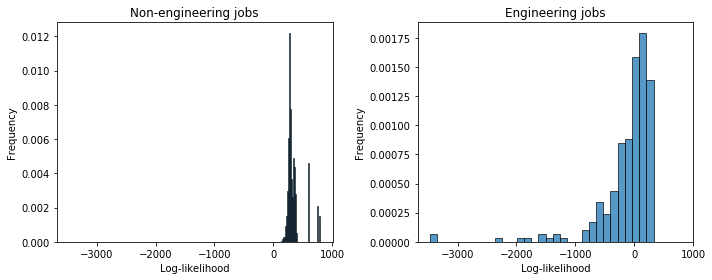

In [61]:
# visualization to see how the data is split

fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharex=True)
sns.histplot(gmm.score_samples(x0_train), stat='density', ax=ax[0])
sns.histplot(gmm.score_samples(x1_train), stat='density', ax=ax[1])

ax[0].set_title('Non-engineering jobs')
ax[1].set_title('Engineering jobs')

for a in ax:
    a.set_xlabel('Log-likelihood')
    a.set_ylabel('Frequency')
    
fig.tight_layout()

In [62]:
# The function in the following cell is copied from the notebook provided by the lecturer. 
# This function is used to obtaint he precision, recall and fscore of each threshold to be tested

from sklearn.metrics import precision_recall_fscore_support
def evaluate_threshold(x, y, thresholds):
    log_likelihoods = gmm.score_samples(x)
    precisions = []
    recalls = []
    f1s = []
    for t in thresholds:
        y_pred = 1 * (log_likelihoods < t)
        p, r, f1, _ = precision_recall_fscore_support(y, y_pred, average='binary')
        precisions.append(p)
        recalls.append(r)
        f1s.append(f1)
    return precisions, recalls, f1s

I want to set up the thresholds for finding the optimal f1 score based on the overlap between the engineering and non-engineering log likelihoods. This is so that I don't have to mannualy reprogram the thresholds when my dataset changes later on.

In [63]:
x0_train_min_score = gmm.score_samples(x0_train).min()
x1_train_max_score = gmm.score_samples(x1_train).max()
delta_score = abs(x1_train_max_score - x0_train_min_score)
thresholds = np.linspace(x0_train_min_score-2*delta_score, x1_train_max_score+2*delta_score, int(delta_score)) #this just defines the "search space" of finding my optimal threshold. 

In [64]:
x_train_combined = np.concatenate([x0_train, x1_train])
y_train_combined = np.concatenate([y0_train, y1_train])
x_test_combined = np.concatenate([x0_test, x1_test])
y_test_combined = np.concatenate([y0_test, y1_test])

In [65]:
p_train, r_train, f1_train = evaluate_threshold(x_train_combined, y_train_combined, thresholds)

Visualization of the claculated precision, recall and f1 scores. 

Text(0.5, 0, 'Thresholds for log-likelihood')

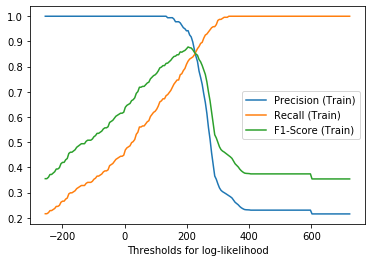

In [66]:
plt.plot(thresholds, p_train, label='Precision (Train)')
plt.plot(thresholds, r_train, label='Recall (Train)')
plt.plot(thresholds, f1_train, label='F1-Score (Train)')
plt.legend()
plt.xlabel('Thresholds for log-likelihood')

Calculating the optimal threshold based on maximum f1 score

In [67]:
best_threshold = thresholds[f1_train.index(max(f1_train))]
best_f1_score = max(f1_train)

In [68]:
print(f'{best_threshold, best_f1_score}')

(203.8553904505886, 0.8780487804878048)


Generating the classification reports

In [69]:
from sklearn.metrics import classification_report

In [70]:
y_train_pred = gmm.score_samples(x_train_combined) < best_threshold

In [71]:
print(classification_report(y_train_combined, y_train_pred))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97       937
           1       0.94      0.82      0.88       241

    accuracy                           0.95      1178
   macro avg       0.95      0.90      0.92      1178
weighted avg       0.95      0.95      0.95      1178



In [72]:
y_test_pred = gmm.score_samples(x_test_combined) < best_threshold

In [73]:
print(classification_report(y_test_combined, y_test_pred))

              precision    recall  f1-score   support

           0       0.94      0.70      0.80       313
           1       0.42      0.81      0.55        81

    accuracy                           0.73       394
   macro avg       0.68      0.76      0.68       394
weighted avg       0.83      0.73      0.75       394



There may be some overfitting because the accuracy on the training dataset is much higher than the testing dataset.

### 7.3 Hyper parameter tunning

There are a number of hyperparameters that are worth tunning to see if I can get better results. For now I will define a function to do this tunning. There are random effects from using k means to initialize the gmm creates too much noise, so the model may also benefit from being trained multiple times, or by setting up fixed initialization states.

In [74]:
from sklearn.metrics import accuracy_score

In [75]:
def gmm_job_class (search='engineering',test_size=0.25,n_comp=1):
    
    #splits the data according to the chosen categories
    col_num = data3.columns.get_loc(search)
    data3_0 = data3[data3.iloc[:,col_num]==0]
    data3_1 = data3[data3.iloc[:,col_num]==1]
    
    #reduced the table size to the desired number of latent dimensions
    red = 150
    data3_0_red = data3_0.iloc[:,63:63+red].assign(cat = data3_0[search])
    data3_1_red = data3_1.iloc[:,63:63+red].assign(cat = data3_1[search])
    
    #creates the training and testing datasets
    np.random.seed(456) #Fixed random seed for reproducability
    x0_train, x0_test, y0_train, y0_test = train_test_split(
        data3_0_red.drop(['cat'], axis=1),
        data3_0_red['cat'],
        test_size=test_size,
    )
    x1_train, x1_test, y1_train, y1_test = train_test_split(
        data3_1_red.drop(['cat'], axis=1),
        data3_1_red['cat'],
        test_size=test_size,
    )
    
    #sets up the gmm
    gmm = GaussianMixture(n_components=n_comp)
    
    #trains the gmm
    gmm.fit(x0_train)
    
    
    #sets up the thresholds for optimization
    x0_train_min_score = gmm.score_samples(x0_train).min()
    x1_train_max_score = gmm.score_samples(x1_train).max()
    delta_score = abs(x1_train_max_score - x0_train_min_score)
    thresholds = np.linspace(x0_train_min_score-2*delta_score, x1_train_max_score+2*delta_score, int(delta_score))
    
    #Sets up the combined datasets for testing later
    x_train_combined = np.concatenate([x0_train, x1_train])
    y_train_combined = np.concatenate([y0_train, y1_train])
    x_test_combined = np.concatenate([x0_test, x1_test])
    y_test_combined = np.concatenate([y0_test, y1_test])
        
    #finds the f1 value for each threshold   
    _,_, f1_train = evaluate_threshold(x_train_combined, y_train_combined, thresholds)
    
    #finds the best threshold to use
    best_threshold = thresholds[f1_train.index(max(f1_train))]
    
    #makes the prediction on the testing dataset
    y_test_pred = gmm.score_samples(x_test_combined) < best_threshold
    
    return accuracy_score(y_test_combined,y_test_pred) 


#### 7.3.1 Varying the n_comp value of the gmm model

The n_comp value is the number of component gaussian models that we want to use to represent the data. as n_comp increases, so does computational cost, but is necessary if the data is very complicated.

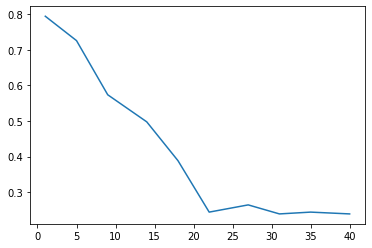

In [76]:
acc=[]
for i in np.linspace(1,40,10).astype(int):
    temp = gmm_job_class(n_comp = i)
    acc = acc + [temp]
    
axis = np.linspace(1,40,10).astype(int)
plt.plot(axis, acc)

As the number of components increase, the number accuracy definately decreases. This is because in this case, the data is very simple and there really is only one category, so adding more components just makes the model worse as it will try to fit something that is not there.

#### 7.3.2 Varying the proportion of testing vs training set

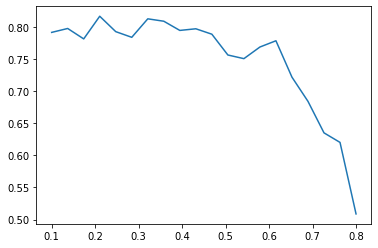

In [77]:
acc=[]
for i in np.linspace(0.1,0.8,20):
    temp = gmm_job_class(test_size = i)
    acc = acc + [temp]

axis = np.linspace(0.1,0.8,20)
    
plt.plot(axis, acc)

The accuracy falls off when the test size gets too big, which is expected. As a lerger proportion of the data is carved out for testing, the model is being trained on less remianing data, making it a worse model.

#### 7.3.3 Varying which job category we are fitting

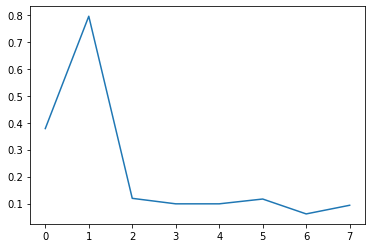

In [78]:
acc=[]
for i in jobcat_reduced.index[2:10]:
    temp = gmm_job_class(search = i)
    acc = acc + [temp]

plt.plot(acc)


In [79]:
pd.DataFrame(jobcat_reduced.index[2:10])

,0
0,technology
1,engineering
2,others
3,administration support
4,policy formulation
5,education
6,statistics
7,research and analysis


Interestingly, engineering has a higher accuracy than the other job categories. My initial intuition that engineering jobs would be easier to identify using the method might have been correct. 

In [80]:
print(f'Test accuracy for engineering using gmm is {round(acc[1],3)}')

Test accuracy for engineering using gmm is 0.794


### 7.4 Conclusion

In this section, I have attempted to use a Gaussian Mixture model to predict whether a particular job description belongs to a job which falls into a particular job category. This is a useful method to develop because the same method could be applied to skills taggings. This is very important because HR as a field is moving towards compensating for skills rather than just compensating for the job. This is something that a company that Jobtech is working on, and it has been a very interesting exercise for me to try an replicate some of their functionas. 

Since GMM is an unsupervised learning method, so it does not make sense to perfrom cross validation for model selection. However, it could still benefit from having each model run multiple times since there is randomness built into the initialization of the model.

To further improve the predictions, I could also train multiple GMM models for each of the job categories, and use these models to predict the combination of job categories for each job. This ensemble method might yield a higher accuracy than just the individual models. However, this would not be within the scope of this project, but it would be very interesting to try.

# Supervised Learning Methods

In this section, I will explore the following methods:
1. Linear Regression
2. Decision Trees
3. Neural Networks

Throughout the next few sections, I will focues on the task of predicting whether a job description falls into the job category of engineering. To make this prediction I will use only the Latent Dimensions calculated using the PCA analysis from the earlier section. 

The reason why engineering was chosen is because the GMM modeling in the prior section showed that engineering might be easier than the other job categories to predict, likely due tot he presence of important keywords. It is also one of the few job categories that can be found in a relatively large portion of the data, making it a good candidate for a project. 

## 8. Linear Regression

Linear regression is the simplest of all the machine learning models, and is also one of the easiest to implement. I will explote simple and logistic regression to predict engineering jobs, and I will also attempt a multicalss logistic regression out of curiosity to see how well I can predict multiple job cetegories at the same time, since the code is also rather easy to implement

In [81]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

In [82]:
#Sets up the training and testing datasets

np.random.seed(456)
x = data3.iloc[:,63:]
y = data3['engineering']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

### 8.1 Simple Linear Regression

In [83]:
#Straight forward linear regression fit

lrg = LinearRegression()
lrg.fit(x_train, y_train)
print(
    f' Train Accuracy: {round(lrg.score(x_train,y_train),3)} \
    \n Test Accuracy: {round(lrg.score(x_test,y_test),3)}'
)

 Train Accuracy: 0.637     
 Test Accuracy: 0.524


In [84]:
#Cross validation of the linear model. 

np.random.seed(456)
scores = cross_val_score(lrg, x_train, y_train, cv=10)
print(
    f' CV Accuracy: {round(np.mean(scores),3)} \
    \n CV Std Accuracy: {round(np.std(scores),3)}'
)

 CV Accuracy: 0.52     
 CV Std Accuracy: 0.088


The simple linear regression give us a poor accuracy, which is to be expected. It is unlikely that there is a linear relationship between the 150 latent dimensions and the engineering job category. 

### 8.2 Logistic Regression

In [85]:
#Straight forward logistic regression fit

clf = LogisticRegression(
    solver='lbfgs',
)
clf.fit(x_train, y_train)
print(
    f' Train Accuracy: {round(clf.score(x_train,y_train),3)} \
    \n Test Accuracy: {round(clf.score(x_test,y_test),3)}'
)

 Train Accuracy: 0.893     
 Test Accuracy: 0.879


In [86]:
#Cross validation of the linear model. 

scores = cross_val_score(clf, x_train, y_train, cv=10)
print(
    f' CV Accuracy: {round(np.mean(scores),3)} \
    \n CV Std Accuracy: {round(np.std(scores),3)}'
)

 CV Accuracy: 0.877     
 CV Std Accuracy: 0.019


The logistic regression has done surprisingly well.

### 8.3 Multiclass Logistic Regression

The code below selects which job categories I want to use in my multicalss regression. I'm choosing new media communications, engineering and technology because these three categories are "hot jobs" that most jobs in my database are currently tagged to. 

In [87]:
#Sets up a dataset with the few categories that I want to try predicting

search_cols = data3.columns
sel_job_cats = [search_cols.get_loc('new media communications'),
search_cols.get_loc('engineering'),
search_cols.get_loc('technology')]

data_multi = data3[data3.iloc[:,sel_job_cats].sum(axis=1)!=0]

In [88]:
len(data_multi), len(data3)

(807, 1572)

There are 807 jobs in at least one of these categories out of 1572 (51.3%) jobs in the database.

In [89]:
x = np.array(data_multi.iloc[:,63:])
y = data_multi.iloc[:,sel_job_cats]

##The model cannot handle vectors like [1,0,0], it must be encoded as some number ie 100, for example. 
y = np.array(9000+y.iloc[:,0]*100+y.iloc[:,1]*10+y.iloc[:,2]) 

# Sets up the training and testing datasets
np.random.seed(456)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

#### 8.3.1 Multinomial

In [90]:
clf = LogisticRegression(
    multi_class='multinomial',
    solver='lbfgs',
)
clf.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [91]:
y_hat_train = clf.predict(x_train)
y_hat_test = clf.predict(x_test)

print(
    f'Using multinomial multiclass regression\
    \n Train Accuracy: {(y_hat_train == y_train).mean()} \
    \n Test Accuracy: {(y_hat_test == y_test).mean()}'
)

Using multinomial multiclass regression    
 Train Accuracy: 0.8496124031007752     
 Test Accuracy: 0.8333333333333334


#### 8.3.2 OVR (One-versus-rest)

In [92]:
clf2 = LogisticRegression(
    multi_class='ovr',
    solver='lbfgs',
)
clf2.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [93]:
y_hat_train = clf2.predict(x_train)
y_hat_test = clf2.predict(x_test)

print(
    f' using one-versus-rest multiclass regression \
    \n Train Accuracy: {(y_hat_train == y_train).mean()} \
    \n Test Accuracy: {(y_hat_test == y_test).mean()}'
)

 using one-versus-rest multiclass regression     
 Train Accuracy: 0.8294573643410853     
 Test Accuracy: 0.808641975308642


Comparing the two types of multiclass regression methods, multinomial and one verus rest, it seems that in this case the multinomial regression does better. 


#### 8.3.3 Cross-Validation

The cross-validation results aren't really expected to be that much different, but I will perform the cross validaiton for completeness' sake.

In [94]:
from sklearn.model_selection import cross_val_score

In [95]:
scores = cross_val_score(clf, x_train, y_train, cv=10)
print(f'Mean accuracy: {round(np.mean(scores),3)}')
print(f'Std accuracy: {round(np.std(scores),3)}')

Mean accuracy: 0.825
Std accuracy: 0.045


In [96]:
scores = cross_val_score(clf2, x_train, y_train, cv=10)
print(f'Mean accuracy: {round(np.mean(scores),3)}')
print(f'Std accuracy: {round(np.std(scores),3)}')

Mean accuracy: 0.814
Std accuracy: 0.052


The cross validation scores are similar between the multinomial and ovr models

## 9. Decision Trees

In this section, I will try to predict the engineering job category using decision trees. I will first do a first round of tunning using a simple decision tree, then I will use an improved decision tree to perfrom bagging and boosting to come up with an even better model. I will then do another round of tunning using a grid search method to arrive at the best possible model for a decision tree for this problem.

In [97]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

In [98]:
# Setting up the training and testing datasets

np.random.seed(456)
x = data3.iloc[:,63:]
y = data3['engineering']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

### 9.1 Simple decision tree

We will start with a simple and small decision tree to serve as a baseline for comparison when we tune the model later on.

In [99]:
np.random.seed(456)
clf = DecisionTreeClassifier(max_depth=3)
clf.fit(x_train, y_train)
train_acc = clf.score(x_train, y_train)
test_acc = clf.score(x_test, y_test)
print(f' Training Accuracy: {round(train_acc,3)}\
        \n Testing Accuracy: {round(test_acc,3)}')
scores = cross_val_score(clf, x_train, y_train, cv=10)
print(f' Mean CV accuracy: {round(np.mean(scores),3)}')
print(f' Std CV accuracy: {round(np.std(scores),3)}')

 Training Accuracy: 0.905        
 Testing Accuracy: 0.889
 Mean CV accuracy: 0.87
 Std CV accuracy: 0.017


Wtih these settings we can already see that it is showing a performance that is similar to that of the logistic regression model, which gave a CV accuracy of 0.877. 

#### 9.1.1 Plot Tree

Using the `plot_tree` fuction helps us to fisualize the various decisions the model is making to split up the dataset. With this we can observe which latent dimensions the model is using the make the decision about whether the job is an engineering job or not, and this may contain some useful informaiton when we unpack the latent dimensions

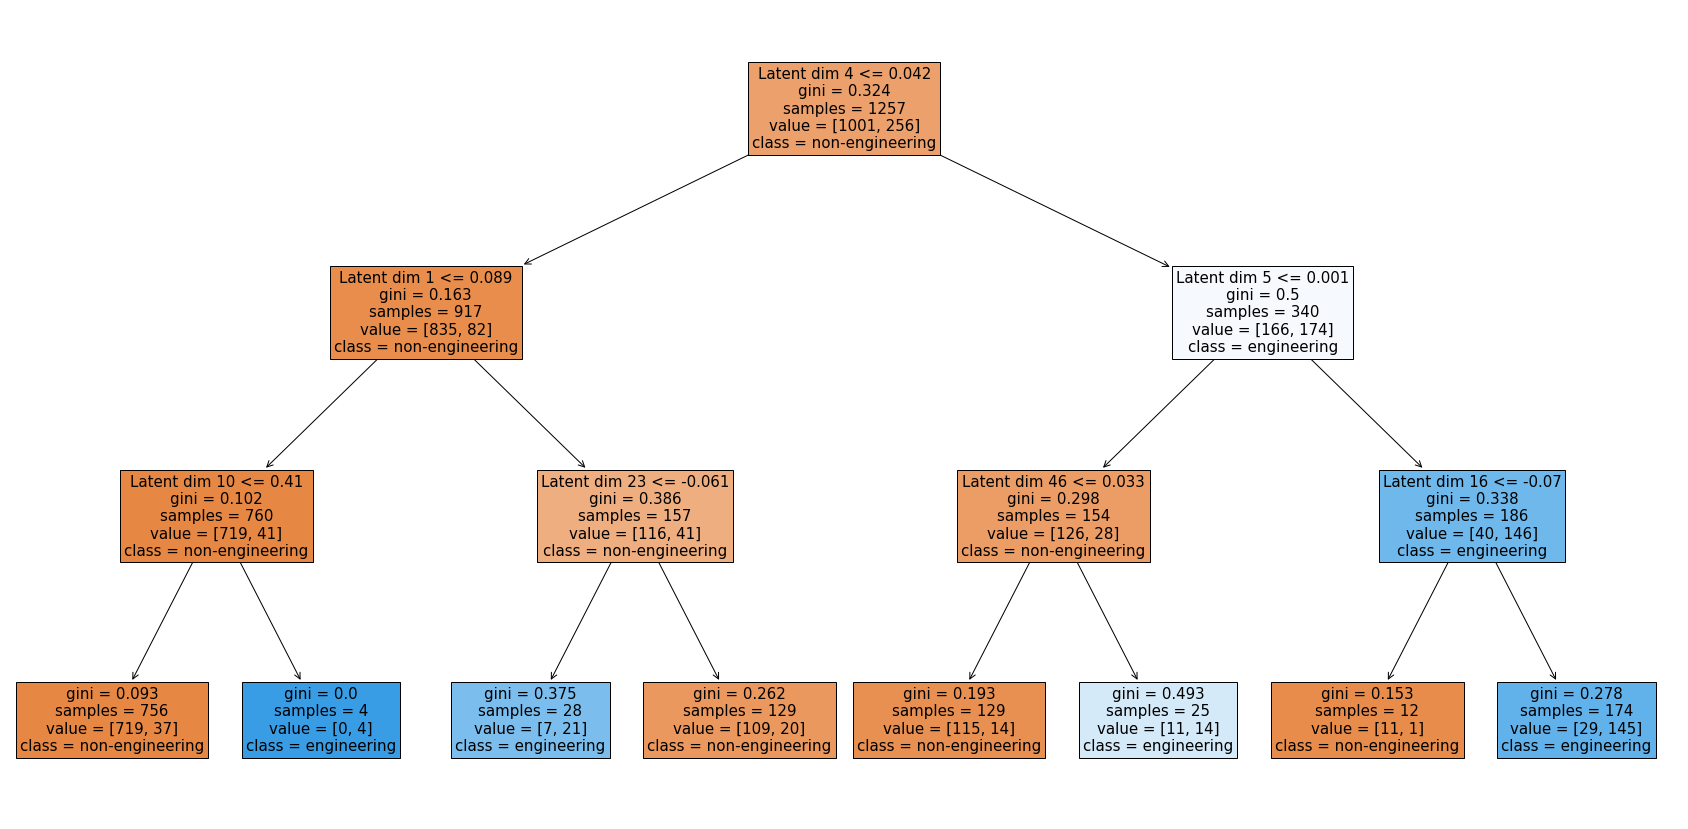

In [100]:
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (30,15))
plot_tree(
    clf,
    feature_names=x_train.columns,
    class_names=['non-engineering','engineering'],
    filled=True,
    fontsize=15
)
print("")

The code below plots the top 5 components of each of the letent dimensions that the decision tree model has identified.
The `top_comp` function was defined much earlier in this notebook, under the PCA section. 
The `top_comp_barplot` function can also be used to visualize the relative weightages of the keywords, which is also imporatnt information

In [101]:
top_comp(4,5),top_comp(15,5),top_comp(9,5),top_comp(22,5)

(Index(['data', 'development', 'edb', 'digital', 'marketing'], dtype='object'),
 Index(['hr', 'engineering', 'defence', 'tax', 'project'], dtype='object'),
 Index(['scdf', 'digital', 'tax', 'edb', 'iras'], dtype='object'),
 Index(['edb', 'financial', 'service', 'healthcare', 'social'], dtype='object'))

### 9.2 Hyperparameter tunning of the decision trees

We will first define a class called `DTCEvaluator` which accieves the same result as the function I wrote for the GMM model tunning, but in a more elegant and general manner. It creates an object with a set of default attributes that will be applied to an evaluate function. The evaluate function will refer to the default attributes each time so that the model can be trained with the same parameters every time. Additionally, the evaluate function allows for overrides, so that we can change one or more of the default attributes stored in the class easily while keeping the rest of the attributes consistent. 

Finally, the model resets itself at the end of the evaluate function after the desired training result has bene obtained. This ensures that each run of the evaluate function is clean. Nevertheless, the reset can be turned off by the user should they desire to store a trained model within the class to be accessed via `self.model`

In [102]:
# This block of code is credited to the DSA5102_nn demo, but I have adapted it to use for decision trees. 

class DTCEvaluator(object):
    def __init__(self,
                 compile_default,
                 fit_default,
                 cv_default,
                 test_default
                ):
        self.model = DecisionTreeClassifier(**compile_default)
        self.compile_default = compile_default
        self.fit_default = fit_default
        self.cv_default = cv_default
        self.test_default = test_default

    def evaluate(self, cv=None, reset = True, **overrides):
        
        #overide for cv
        if cv == None:
            cv = self.cv_default
        
        # override for compile
        compile_overrides = {
            k: v
            for k, v in overrides.items() if k in self.compile_default.keys()
        }
        compile_updated = {**self.compile_default, **compile_overrides}
        self.model = DecisionTreeClassifier(**compile_updated)

        # override for fit
        fit_overrides = {
            k: v
            for k, v in overrides.items() if k in self.fit_default.keys()
        }
        fit_updated = {**self.fit_default, **fit_overrides}
        
        # override for test
        test_overrides = {
            k: v
            for k, v in overrides.items() if k in self.test_default.keys()
        }
        test_updated = {**self.test_default, **test_overrides}           
        
        # The actual work
        self.model.fit(**fit_updated)
        train_scores = self.model.score(**fit_updated)
        test_scores = self.model.score(**test_updated)
        cv_scores = cross_val_score(self.model, fit_updated['X'], fit_updated['y'], cv=cv)
        
        #This line resets the model back to the original settings. The model that has been fitted is removed as a result as well. 
        if reset:
            self.model = DecisionTreeClassifier(**self.compile_default)
        
        return cv_scores, train_scores, test_scores
    
    def sum_stat_eval(self, cv=None, reset = True, showplot=True, **overrides):
        
        res = self.evaluate(cv, reset, **overrides)
        scores = res[0]
        if showplot:
            sns.distplot(scores)
        return print(f'Train: {round(res[1],3)}\
                     \n Test: {round(res[2],3)}\
                     \n Mean CV accuracy: {round(np.mean(scores),3)}\
                     \n CV Std accuracy: {round(np.std(scores),3)}')
    
    

#### 9.2.1 Setting up the first model

In [103]:
DTC01 = DTCEvaluator(
    compile_default = {
        'max_depth':3,
        'criterion':'gini'
    },
    fit_default = {'X':x_train,'y':y_train},
    test_default = {'X':x_test, 'y': y_test},
    cv_default = 10
)

In [104]:
DTC01.sum_stat_eval(showplot=False)

Train: 0.905                     
 Test: 0.889                     
 Mean CV accuracy: 0.87                     
 CV Std accuracy: 0.015


#### 9.2.2 Tunning the parameters

I could use the grid search function, but I wanted to do this mannually for my own learning

In [105]:
def badplot():
    plt.plot(cv_acc, label = 'cv')
    plt.plot(train_acc, label = 'train')
    plt.plot(test_acc, label = 'test')
    plt.legend()

This function is just a quick and dirty way to plot the results that we want to see

#### 9.2.3 Using different max depths

In [106]:
cv_acc = []
train_acc = []
test_acc = []

np.random.seed(456)

for i in range(1,10,1):
    res = DTC01.evaluate(max_depth = i)
    scores = res[0]
    cv_acc.append(np.mean(scores))
    train_acc.append(res[1])
    test_acc.append(res[2])

A max depth of 6 produces the highest mean accuracy


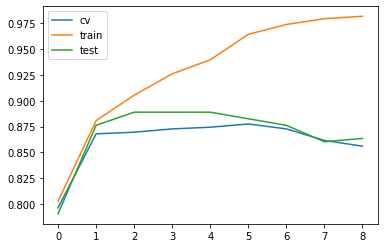

In [107]:
badplot()
ideal = range(1,10,1)[np.argmax(cv_acc)]
print(f'A max depth of {ideal} produces the highest mean accuracy')

#### 9.2.4 Using different cross validation parameters

In [108]:
cv_acc = []
train_acc = []
test_acc = []

np.random.seed(456)

for i in [10,20,30,40]:
    res = DTC01.evaluate(cv= i,max_depth = 6)
    scores = res[0]
    cv_acc.append(np.mean(scores))
    train_acc.append(res[1])
    test_acc.append(res[2])

A cross validation parameter of 20 produces the highest mean accuracy


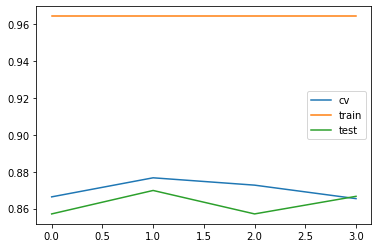

In [109]:
badplot()
ideal = [10,20,30,40][np.argmax(cv_acc)]
print(f'A cross validation parameter of {ideal} produces the highest mean accuracy')

#### 9.2.5 Using different criterion

In [110]:
cv_acc = []
cv_std_acc = []
train_acc = []
test_acc = []


np.random.seed(456)

for i in ['gini','entropy']:
    scores = DTC01.evaluate(cv= 20, max_depth = 6, criterion = i)[0]
    scores = res[0]
    cv_acc.append(np.mean(scores))
    cv_std_acc.append(np.std(scores))
    train_acc.append(res[1])
    test_acc.append(res[2])    

In [111]:
print(f'Gini: {round(cv_acc[0],3)} (std:{round(cv_std_acc[0],3)})')
print(f'Entropy: {round(cv_acc[1],3)} (std:{round(cv_std_acc[1],3)})')

Gini: 0.865 (std:0.053)
Entropy: 0.865 (std:0.053)


No significant difference between using Gini or Entropy, so we can just stick to Gini for now

#### 9.2.6 The Tunned Model

In [112]:
DTC02 = DTCEvaluator(
    compile_default = {
        'max_depth':6,
        'criterion':'gini'
    },
    fit_default = {'X':x_train,'y':y_train},
    test_default = {'X':x_test, 'y': y_test},
    cv_default = 20
)

In [113]:
#We set reset to false here because we want to use DTC02.model in the next few sections
DTC02.sum_stat_eval(reset=False, showplot=False) 

Train: 0.964                     
 Test: 0.873                     
 Mean CV accuracy: 0.882                     
 CV Std accuracy: 0.025


### 9.3 Random Forest (Bagging)

In [114]:
from sklearn.ensemble import RandomForestClassifier

In [115]:
np.random.seed(456)
rfb = RandomForestClassifier(n_estimators=100, max_depth=6)
rfb.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [116]:
np.random.seed(456)
print(f'Train accuracy: {rfb.score(x_train, y_train).round(3)}')
print(f'Test accuracy: {rfb.score(x_test, y_test).round(3)}')
scores = cross_val_score(rfb, x_train, y_train, cv=10)
print(f'Mean CV accuracy: {np.mean(scores).round(3)}')
print(f'CV Std accuracy: {np.std(scores).round(3)}')

Train accuracy: 0.917
Test accuracy: 0.873
Mean CV accuracy: 0.867
CV Std accuracy: 0.012


### 9.4 AdaBoost (Boosting)

In [117]:
from sklearn.ensemble import AdaBoostClassifier

In [118]:
adb = AdaBoostClassifier(
    DTC02.model,
    n_estimators=5,
)

In [119]:
adb.fit(x_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=6,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                          

In [120]:
print(f'Train accuracy: {adb.score(x_train, y_train).round(3)}')
print(f'Test accuracy: {adb.score(x_test, y_test).round(3)}')
scores = cross_val_score(adb, x_train, y_train, cv=20)
print(f'Mean CV accuracy: {np.mean(scores).round(3)}')
print(f'CV Std accuracy: {np.std(scores).round(3)}')

Train accuracy: 1.0
Test accuracy: 0.844
Mean CV accuracy: 0.834
CV Std accuracy: 0.046


### 9.5 Hyper Parameter Tunning (part 2)

This time using `GridSearchCV`. This method allows me to do a fine tuning of all the parameters used in the AdaBoost classifier instead of wirting my own code to tune the hyperparameters.

In [121]:
from sklearn.model_selection import GridSearchCV

In [122]:
# This code sets up all the parameters I want to tune
# The function will search through every combination of these parameters (i.e. 3x2x3x3 = 54 models)

param_grid = {
    'base_estimator__max_depth': [5, 6, 7],
    'base_estimator__criterion': ['gini', 'entropy'],
    'n_estimators': [5, 25, 50],
    'learning_rate': [0.01, 0.1, 1.0],
}

In [123]:
adb_grid = GridSearchCV(estimator=adb, param_grid=param_grid, cv=4)

In [124]:
#This line of code takes a reallyyyy long time to run
#np.random.seed(456)
#adb_grid.fit(x_train, y_train)
#dump(adb_grid,'adaboost_grid.joblib')
adb_grid = load('adaboost_grid.joblib')

In [125]:
adb_grid.best_params_

{'base_estimator__criterion': 'entropy',
 'base_estimator__max_depth': 5,
 'learning_rate': 0.01,
 'n_estimators': 50}

In [126]:
#Reads the results table produced by the 
GrdRes = pd.DataFrame(adb_grid.cv_results_)
mean_cv = GrdRes[GrdRes['rank_test_score']==1]['mean_test_score'].tolist()[0]
std_cv = GrdRes[GrdRes['rank_test_score']==1]['std_test_score'].tolist()[0]


print(f'Train accuracy: {adb_grid.score(x_train, y_train).round(3)}')
print(f'Test accuracy: {adb_grid.score(x_test, y_test).round(3)}')
print(f'Mean CV accuracy: {round(mean_cv,3)}')
print(f'Std CV accuracy: {round(std_cv,3)}')

Train accuracy: 0.998
Test accuracy: 0.892
Mean CV accuracy: 0.905
Std CV accuracy: 0.003


Note:
`adb_grid.score`: This uses the score defined by scoring where provided, and the `best_estimator_.score` method otherwise.

## 10. Fully Connected Neural Network
    
Fully Connected Neural Networks (FCNN) is the simplest and older type of neural network compared to the convolutional neural network (CNN) and the recurrent neural network (RNN). I choose the FCNN because for my chosen problem because there is no need for the CNN as the latent dimensions that are used to describe the job descriptions are probably permutation invariant, i.e. there is no particular order in which the latent dimensions need to be in. Nevertherless, it would be useful to explore CNNs in a future project. 

RNNs are used on data where the outputs have a temporal structure, like the unprocessed job description text data. In a future project, RNNs could be used to "write" job descriptions just from basic inputs like the job titles and the job categories. 

In [127]:
import keras
from keras.layers import Input, Dense, Flatten
from keras.models import Model
from keras.utils import to_categorical

### 10.1 Setting up the data and models

In [128]:
from keras.losses import categorical_crossentropy
from keras.optimizers import SGD

In [129]:
#This block of code is credited to the DSA5102_nn demo. 

class ParamEvaluator(object):
    def __init__(self,
                 model,
                 compile_default,
                 fit_default,
                 initial_weights=None):
        self.model = model
        self.compile_default = compile_default
        self.fit_default = fit_default
        self.initial_weights = initial_weights or model.get_weights()

    def reset_model(self):
        self.model.set_weights(self.initial_weights)

    def evaluate(self, **overrides):
        # reset model
        self.reset_model()
        
        # override and compile
        compile_overrides = {
            k: v
            for k, v in overrides.items() if k in self.compile_default.keys()
        }
        compile_updated = {**self.compile_default, **compile_overrides}
        self.model.compile(**compile_updated)

        # override and fit
        fit_overrides = {
            k: v
            for k, v in overrides.items() if k in self.fit_default.keys()
        }
        fit_updated = {**self.fit_default, **fit_overrides}
        history = self.model.fit(**fit_updated)
        
        history_df = pd.DataFrame(history.history)
        history_df['epoch'] = history.epoch
        return history_df
    
    def graphluate(self, title='', **overrides):
        
        table = self.evaluate(**overrides)
        
        fig, ax = plt.subplots(1, 2, figsize=(10, 4))

        table.plot(x='epoch', y=['loss', 'val_loss'], ax=ax[0])
        table.plot(x='epoch', y=['accuracy', 'val_accuracy'], ax=ax[1])
        ax[0].title.set_text(title)
        
        return table

### 10.2 Shallow FCNN for predicting Agency

I this part I will first look as how the FCNN performs in predicting which agency the job description is from, rather than whether we have an engineering job. This is because my guess that it is easier to have the input size to be similar to the output size on the neural network. There are 150 latent dimensions and 90 agencies, whereas there are only 2 outputs when predicting engineering jobs, engineering and non-engineering. 

I will explore predicting the agency using a shallow FCNN and take a look at how the hyper parameters affect the performance of the model. Then, I will use this to construct a deep FCNN to predict engineering jobs

In [130]:
x = data3.iloc[:,63:]
y = data3.iloc[:,3]
y = pd.get_dummies(y).to_numpy()

In [131]:
np.random.seed(456)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [132]:
x = Input(shape=(150,))
x_1 = Dense(units=115, activation='relu')(x)
x_2 = Dense(units=90, activation='softmax')(x_1)
mdl01 = Model(inputs=x, outputs=x_2)

In [133]:
snn1 = ParamEvaluator(
    model = mdl01,
    compile_default = {
        'loss': categorical_crossentropy,
        'optimizer': SGD(0.5),
        'metrics':['accuracy'], 
    },
    fit_default={
        'x':x_train,
        'y':y_train,
        'batch_size':300,
        'epochs':250,
        'validation_data':(x_test, y_test),
        'verbose': 0,
        'validation_split': 0.2
    }
)

#### 10.2.1 The effects of changing SGD

,SGD,Mean val_accuracy of last 25 epochs
0,0.2,0.572222
1,0.5,0.712063
2,1.0,0.762381


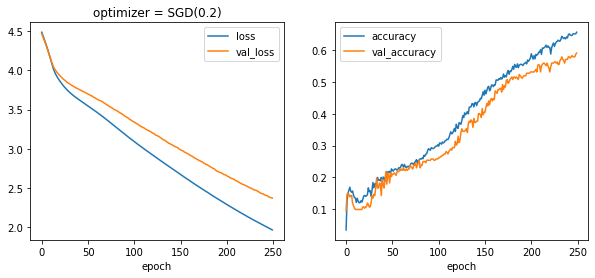

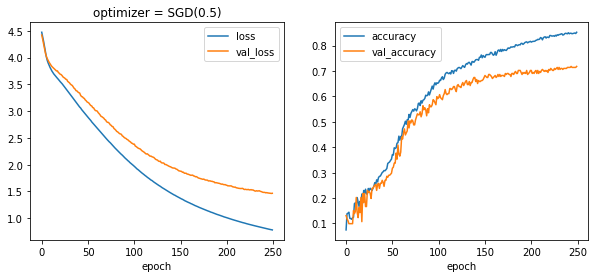

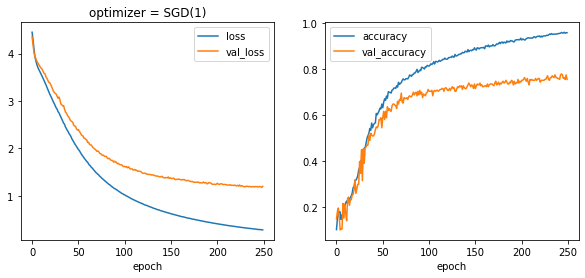

In [134]:
acc = []

for i in [0.2,0.5,1]:
    store = snn1.graphluate(optimizer=SGD(i), title = f'optimizer = SGD({i})')['val_accuracy']
    acc.append(np.mean(store[-25:]))
    
sgd = pd.DataFrame({'SGD': [0.2,0.5,1], 'Mean val_accuracy of last 25 epochs':acc})
sgd

#### 10.2.2 Effect of changing validation split

,Validation Split,Mean val_accuracy of last 25 epochs
0,0.1,0.714603
1,0.2,0.712381
2,0.5,0.688394


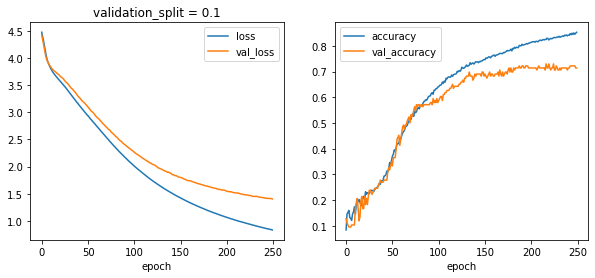

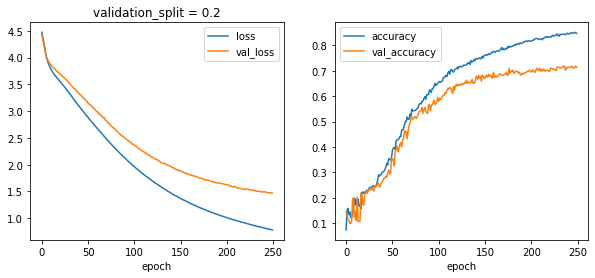

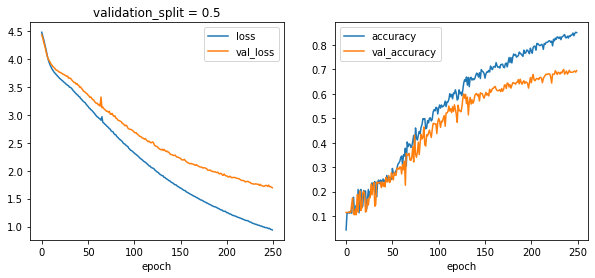

In [135]:
acc = []

for i in [0.1,0.2,0.5]:
    store = snn1.graphluate(validation_split = i, title = f'validation_split = {i}')['val_accuracy']
    acc.append(np.mean(store[-25:]))
    
VS = pd.DataFrame({'Validation Split': [0.1,0.2,0.5], 'Mean val_accuracy of last 25 epochs':acc})
VS

#### 10.2.3 Effect of chaniging batch size

,Batch Size,Mean val_accuracy of last 25 epochs
0,100,0.773810
1,300,0.711270
2,600,0.641905


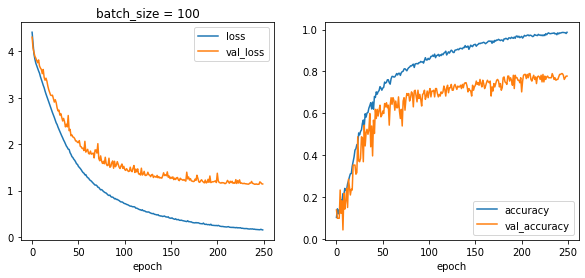

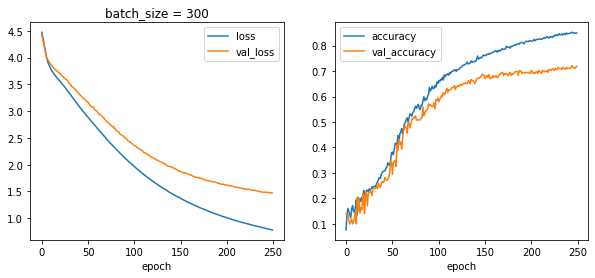

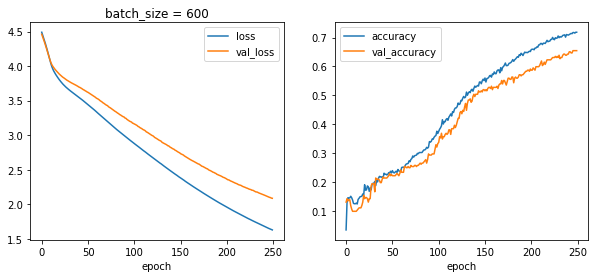

In [136]:
acc = []

for i in [100,300,600]:
    store = snn1.graphluate(batch_size=i, title = f'batch_size = {i}' )['val_accuracy']
    acc.append(np.mean(store[-25:]))
    
BS = pd.DataFrame({'Batch Size': [100,300,600], 'Mean val_accuracy of last 25 epochs':acc})
BS

In [137]:
sgd.index = sgd.iloc[:,0]
VS.index = VS.iloc[:,0]
BS.index = BS.iloc[:,0]

In [138]:
print(f'{sgd.iloc[:,1]}\
\n\n{VS.iloc[:,1]}\
\n\n{BS.iloc[:,1]}\
')

SGD
0.2    0.572222
0.5    0.712063
1.0    0.762381
Name: Mean val_accuracy of last 25 epochs, dtype: float64

Validation Split
0.1    0.714603
0.2    0.712381
0.5    0.688394
Name: Mean val_accuracy of last 25 epochs, dtype: float64

Batch Size
100    0.773810
300    0.711270
600    0.641905
Name: Mean val_accuracy of last 25 epochs, dtype: float64


Unsurprisingly, we see that the learning rate of the SGD has the biggest impact on the performance of the model. This is because it determines how large a step the model takes each time it perfroms a gradient descent. If the rate is too small, then the model will got get to the optimal result quickly, but if it is too lage, it will not reach the optimal solution at all, as it would be hidden by random noise as the model jumps around eratically. 

Batch size also has some impact, which is the opposite of the SGD learning rate. In this case we are using mini-batchs with a size smaller than our sample size, which means that each epoch would be made up of multiple iterations. The smaller the batch size the more noise is introduced into the data. 

Validation Split increases the gap between the training and the testing accuracy. Generally it is not good to have a large validation split and it really depends on the size of the dataset. 

#### 10.2.4 Creating a slightly deeper neural network for predicting agencies

A deeper neural network can be made by adding more layers. Each layer can have a differnet number of units, and the performance of the model depends on the number of units. With each additional layer the time it takes to train the model increases.

In [139]:
x = Input(shape=(150,))
x_1 = Dense(units=130, activation='relu')(x)
x_2 = Dense(units=110, activation='relu')(x_1)
x_3 = Dense(units=100, activation='relu')(x_2)
x_4 = Dense(units=90, activation='softmax')(x_3)
mdl02 = Model(inputs=x, outputs=x_4)

mdl02.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150)]             0         
_________________________________________________________________
dense_2 (Dense)              (None, 130)               19630     
_________________________________________________________________
dense_3 (Dense)              (None, 110)               14410     
_________________________________________________________________
dense_4 (Dense)              (None, 100)               11100     
_________________________________________________________________
dense_5 (Dense)              (None, 90)                9090      
Total params: 54,230
Trainable params: 54,230
Non-trainable params: 0
_________________________________________________________________


These parameters were determined after some brief experimentation, but wihout every extensive tunning

In [140]:
snn2 = ParamEvaluator(
    model = mdl02,
    compile_default = {
        'loss': categorical_crossentropy,
        'optimizer': SGD(0.03),
        'metrics':['accuracy'], 
    },
    fit_default={
        'x':x_train,
        'y':y_train,
        'batch_size':400,
        'epochs':1200,
        'validation_data':(x_test, y_test),
        'verbose': 0
    }
)

As the number of layers increased, the number of epochs needed to acheieve a good result increased. In this case, I needed about 1200 epochs but the performance still did not beat the shallow neural network. There could be something wrong with the way i initially designed the neural network in the first place. 

0.6600635123252868

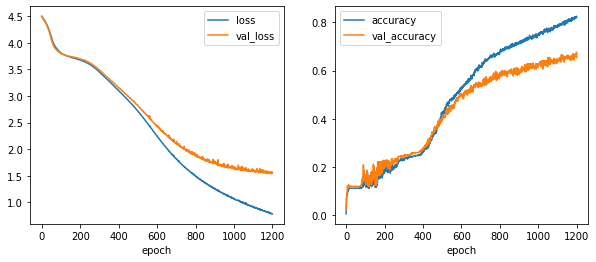

In [141]:
np.mean(snn2.graphluate()['val_accuracy'][-25:])

Just a slight tweak to the SGD settings and reducing the batch size shows a very interesting behaviour where the `val_loss increases` while the `val_accuracy` flattens after 400. At the same time the loss and accuracy continue decreasing and increasing respectively. This is a clear sign of overfitting, which is to be expected because the number of epochs used here is really high.

0.6876190662384033

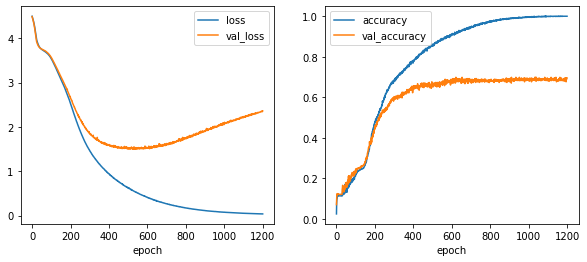

In [142]:
np.mean(snn2.graphluate(optimizer=SGD(0.025), batch_size=100)['val_accuracy'][-25:])

I won't tune this model for this project because there are too many factors that could be tunned, including the number of layers and the shape of each layer. Instead, I will work on the deep FCNN for predicting engineering jobs, which is the goal of this section of my project.

### 10.3 Back to the problem of predicting engineering jobs using deep FCNN

Having trained the shallow NN to show the various effect of adjusting some of the hyperparameters, I will present my deep FCNN below, but wihtout presenting all the hyperparameter tunning, as it would take up too much time. 

In [143]:
# Setting up the training and testing datasets

np.random.seed(456)
x = data3.iloc[:,63:]
y = data3['engineering']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

y_train = to_categorical(y_train, num_classes=2)  # convert to one-hot
y_test = to_categorical(y_test, num_classes=2)

In [144]:
x = Input(shape=(150,))
x_1 = Dense(units=75, activation='relu')(x)
x_2 = Dense(units=50, activation='relu')(x_1)
x_3 = Dense(units=20, activation='relu')(x_2)
x_4 = Dense(units=2, activation='sigmoid')(x_3)
mdl03 = Model(inputs=x, outputs=x_4)

mdl03.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 150)]             0         
_________________________________________________________________
dense_6 (Dense)              (None, 75)                11325     
_________________________________________________________________
dense_7 (Dense)              (None, 50)                3800      
_________________________________________________________________
dense_8 (Dense)              (None, 20)                1020      
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 42        
Total params: 16,187
Trainable params: 16,187
Non-trainable params: 0
_________________________________________________________________


In [145]:
snn3 = ParamEvaluator(
    model = mdl03,
    compile_default = {
        'loss': categorical_crossentropy,
        'optimizer': SGD(0.5),
        'metrics':['accuracy'], 
    },
    fit_default={
        'x':x_train,
        'y':y_train,
        'batch_size':100,
        'epochs':500,
        'validation_data':(x_test, y_test),
        'verbose': 0,
        'validation_split': 0.1
    }
)

,SGD,Mean val_accuracy of last 25 epochs
0,0.005,0.753968
1,0.010,0.915238
2,0.020,0.904127


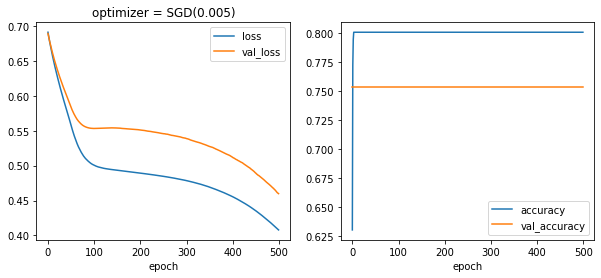

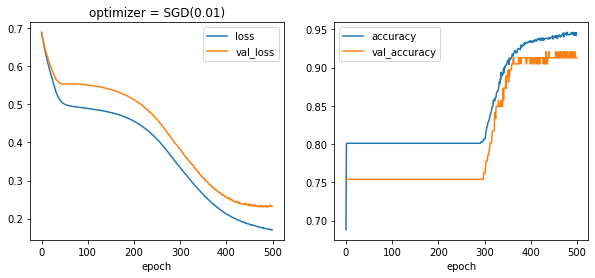

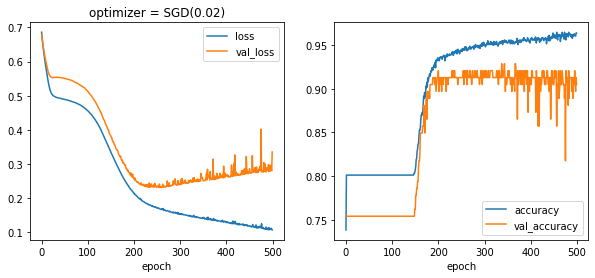

In [146]:
acc = []

for i in [0.005,0.01,0.02]:
    store = snn3.graphluate(optimizer=SGD(i), title = f'optimizer = SGD({i})')['val_accuracy']
    acc.append(np.mean(store[-25:]))
    
pd.DataFrame({'SGD': [0.005,0.01,0.02], 'Mean val_accuracy of last 25 epochs':acc})

From the above, we can see that a learning rate of 0.01 is the sweet spot for this model. at 0.05 it runs too slow and gets underfitted, while at a learning rate of 0.02 it gets overfitted after 200 epochs without really stabilizing. A potential further optimization would be to reduce the number of epochs slightly, but I think that's not necessary for the purposes of this assignment.

Now, I run the neural netowork repeatedly to simulate the effect of cross validation in eliminating randomness in the result over each run (wihout actually performing cross validation, since the data use is the same each time). This is not very necessary as averaging over epochs gives a pretty good rough estimate already since each epoch is run via mini-batches, but I did it anyway. The code is commented out and the results I obtained when I did run the code are printed below. 

In [147]:
#repres = []

#for i in range(1,11):
#    repres.append(np.mean(snn3.evaluate(optimizer=SGD(0.01))['val_accuracy'][-25:]))

#print(f' Repeated Mean: {np.mean(repres).round(3)}\
#        \n Repeated Std: {np.std(repres).round(3)}')

In [148]:
print(f' Repeated Mean: 0.921  \
        \n Repeated Std: 0.001')

 Repeated Mean: 0.921          
 Repeated Std: 0.001


## 11. Comparing the performance of the various models

GMM, Linear Regression, Decision Trees and FCNNS have been all been used to try to solve the problem of predicting whether a job is in the engineering job category. 20% of the jobs are in the engineering job category, so only accuracies greater than 80% are worth writting home about. In this regard, only GMM and simple linear regression were unsuccessful models. However, my analysis is only limited to accuracy, as it is the easiest to obtain, but for a more robust analysis, we need to look at the precision, recalll and f1-score as well. 

The data below is copied from my runs before submitting this assignement. They may be different from the actual values when some of the models are rerun.

In [149]:
final_results = pd.DataFrame(
    {
        'Train': [0.637,0.893,0.905,0.964,0.917,1.00,0.998,"-","-"],
        'Test': [0.524,0.879,0.889,0.873,0.873,0.844,0.892,"-","-"],
        'CV' : [0.520,0.877,0.870,0.882,0.867,0.838,0.905,0.921,0.794],
        'Std' : [0.088,0.019,0.015,0.025,0.012,0.042,0.003,0.001,"-"]
    
    }
)

final_results.index = ['Simple Linear Regression','Logistic Regression','Decision Tree 1 (DTC01)', 'Decision Tree 2 (DTC02)','DTC02_Bagging','DTC02_Boosting','DTC02_Boosting(GridTunned)','Deep FCNN','GMM']
final_results['Rank'] = final_results['CV'].rank(ascending=False)
final_results

,Train,Test,CV,Std,Rank
Simple Linear Regression,0.637,0.524,0.520,0.088,9.0
Logistic Regression,0.893,0.879,0.877,0.019,4.0
Decision Tree 1 (DTC01),0.905,0.889,0.870,0.015,5.0
Decision Tree 2 (DTC02),0.964,0.873,0.882,0.025,3.0
DTC02_Bagging,0.917,0.873,0.867,0.012,6.0
DTC02_Boosting,1,0.844,0.838,0.042,7.0
DTC02_Boosting(GridTunned),0.998,0.892,0.905,0.003,2.0
Deep FCNN,-,-,0.921,0.001,1.0
GMM,-,-,0.794,-,8.0


In [150]:
final_results.sort_values('Rank')

,Train,Test,CV,Std,Rank
Deep FCNN,-,-,0.921,0.001,1.0
DTC02_Boosting(GridTunned),0.998,0.892,0.905,0.003,2.0
Decision Tree 2 (DTC02),0.964,0.873,0.882,0.025,3.0
Logistic Regression,0.893,0.879,0.877,0.019,4.0
Decision Tree 1 (DTC01),0.905,0.889,0.870,0.015,5.0
DTC02_Bagging,0.917,0.873,0.867,0.012,6.0
DTC02_Boosting,1,0.844,0.838,0.042,7.0
GMM,-,-,0.794,-,8.0
Simple Linear Regression,0.637,0.524,0.520,0.088,9.0


Starting from the bottom of the rankings, we can see that Simple Linear Regression does very bad, as is to be expected. With 150 latent dimensions there was never really a good chance that there would be a simple linear relationship to identify the engineering jobs. Logistic regression was the best of the linear models, and does better than some of the decision tress, which shows that you can actually get very far with linear regression alone. Its advantage lies in being very easy to train and does not require much tunning. 

I was hoping that the GMM would do better, but we are also using GMM for something it is not really meant to do. Its advantage lies in being able to produce a prediction in terms of a probability, and also to be able to model more than one job category. With a different set up and a little bit more tunning I believe that the GMM model can still do well. 

Overall, the Deep FCNN model performed the best, and right after that is the very extensively tunned AdaBoost Decision Tree Classifier (DTC). When comparing training time, the deep FCNN is may be slower but the DTC took a long time to optimize while the FCNN did not need to go through a very long optimization process. Thus, I believe that the FCNN has even more potential performance that could be extracted with more tunning. 

## Conclusion

In this project, I have performed dimensionality reduction using PCA and used the results to train a number of machine learning models to predict job categories. For the bulk of the project I was only performing binary classification of engineering and non engineering jobs. For future work, these models could be extended to the more difficult multi-class problem. 

In a small trial of this during the project, the shallow neural network managed to predict the `Agency` that posted the job from the job description latent dimensions with a rather high accuracy. This was a multi-class problem with 90 classes, so it was not trivial to get a high accuracy. The two most well represented agencies by far are GovTech and LTA who each have a prevalence of 10%, while the shallow FCNN managed an accuracy as high as 77%, showing that the FCNN can indeed predict well if given the right datasset. 